## Проект:A/B тестирования подписки дейтингового приложения
Нужно провести аналитику подписки в дейтинговом приложении.

Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

#### Задачи для проверки:

Был ли эксперимент успешен в целом.
*Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.

#### Данные
Всего есть три группы: 

тестовая (test)  
контрольная 1 (control_1)    
контрольная 2 (control_2) 

Для каждой из них:

##### users_*.csv – информация о пользователях:

- uid – идентификатор пользователя
- age – возраст
- attraction_coeff – коэффициент привлекательности (от 0 до 1000, лайки/просмотры∗1000)
- coins – число монеток (внутренняя валюта)
- country – страна  
- visit_days – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)
- gender – пол
- age_filter_start  – фильтр поиска, мин. значение 
- age_filter_end  – фильтр поиска, макс. значение 
- views_count – число полученных оценок 
- was_premium – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный 

##### transactions_*.csv – информация о платежах пользователей:

- uid – идентификатор пользователя
- country – страна
- joined_at – дата и время регистрации
- paid_at – дата и время покупки
- revenue – нормированная выручка
- payment_id – идентификатор платежа
- from_page – откуда пользователь перешел на страницу оплаты
- product_type – тип продукта (trial_premium – пробная премиум-подписка, premium_no_trial - премиум-подписка без пробной, coins - подписка за внутреннюю валюту, other_type - другое) 

##### Файлы:

- users_test – информация о пользователях в тестовой группе.
- users_control_1 – информация о пользователях в первой контрольной группе.
- users_control_2 – информация о пользователях во второй контрольной группе.
- transactions_test – информация о платежах пользователей в тестовой группе.
- transactions_control_1 – информация о платежах пользователей в первой контрольной группе.
- transactions_control_2 – информация о платежах пользователей во второй контрольной группе   

#### Порядок выполнения проекта:

1. Провести EDA для пользователей
2. Провести EDA для транзакций
3. Сделать выводы по EDA анализам
4. Подготовить данные для A/B- тестирования. (Рандомизация)  
   4.1. Возраст  
   4.2. Коэффициент привлекательности  
   4.3. Число монеток (внутренняя валюта)  
   4.4. Страна  
   4.5. Количество дней, проведенное пользователем в приложении   
   4.6. Пол пользователей  
   4.7. Фильтр поиска, мин. значение  
   4.8. Фильтр поиска, макс. значение  
   4.9. Число просмотров  
5. A/B тестирование
6. Вывод

Проведем импорт библиотек и подгрузку всех файлов.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import scipy.stats as ss
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy.stats import mannwhitneyu

In [2]:
users_test=pd.read_csv('Проект_3_users_test.csv',sep=";")
users_control_1=pd.read_csv('Проект_3_users_control_1.csv',sep=";")
users_control_2=pd.read_csv('Проект_3_users_control_2.csv',sep=";")
transactions_test=pd.read_csv('Проект_3_transactions_test.csv',sep=";")
transactions_control_1=pd.read_csv('Проект_3_transactions_control_1.csv',sep=";")
transactions_control_2=pd.read_csv('Проект_3_transactions_control_2.csv',sep=";")

<h2>1. EDA пользователей</h2>

<h3>1.1. EDA users_test</h3>

In [3]:
users_test.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0


In [4]:
users_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4308 entries, 0 to 4307
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4308 non-null   int64  
 1   age               4308 non-null   int64  
 2   attraction_coeff  4308 non-null   int64  
 3   coins             49 non-null     float64
 4   country           4308 non-null   object 
 5   visit_days        2978 non-null   object 
 6   gender            4308 non-null   int64  
 7   age_filter_start  4308 non-null   int64  
 8   age_filter_end    4308 non-null   int64  
 9   views_count       4308 non-null   int64  
 10  was_premium       408 non-null    float64
 11  is_premium        157 non-null    float64
 12  total_revenue     4308 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 437.7+ KB


In [5]:
users_test.shape

(4308, 13)

По полученным данным мы видим, что есть пропущенные значения в столбце coins. Я считаю это нормальным, поскольку у пользователя может не быть этой внутренней валюты (монеток).
Также значения пропущены в столбцах: visit_days, was_premium, is_premium

По условию мы знаем, что visit_days – это в какие дни ПОСЛЕ регистрации пользователь посещал приложение (напр. в 1, затем в 7). Можно считать, что пользователи с пропущенными значениями в vizit_days заходили в приложение только в день регистрации, а потом не заходили.

Сделаем преобразование данных: заменим пропуски во всех столбцах на 0

In [6]:
users_test=users_test.fillna(0)

In [7]:
users_test.isna().sum()

uid                 0
age                 0
attraction_coeff    0
coins               0
country             0
visit_days          0
gender              0
age_filter_start    0
age_filter_end      0
views_count         0
was_premium         0
is_premium          0
total_revenue       0
dtype: int64

In [8]:
users_test.describe()

,uid,age,attraction_coeff,coins,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
count,4.308000e+03,4308.000000,4308.000000,4308.000000,4308.000000,4308.000000,4308.000000,4308.000000,4308.000000,4308.000000,4308.000000
mean,8.917437e+08,31.889276,316.411328,2.614206,0.953110,26.701486,38.248839,50.391133,0.094708,0.036444,534.080316
std,4.547670e+05,10.245287,323.373725,129.608910,0.211427,9.390851,15.344562,318.676437,0.292845,0.187414,4371.682632
min,8.910511e+08,16.000000,0.000000,0.000000,0.000000,13.000000,19.000000,0.000000,0.000000,0.000000,0.000000
25%,8.913621e+08,25.000000,0.000000,0.000000,1.000000,19.000000,28.000000,1.000000,0.000000,0.000000,0.000000
50%,8.917290e+08,30.000000,250.000000,0.000000,1.000000,24.000000,35.000000,6.000000,0.000000,0.000000,0.000000
75%,8.920952e+08,38.000000,520.250000,0.000000,1.000000,32.000000,44.000000,22.000000,0.000000,0.000000,0.000000
max,9.051586e+08,99.000000,1000.000000,8466.000000,1.000000,96.000000,102.000000,12831.000000,1.000000,1.000000,129870.000000


In [9]:
(users_test.query('is_premium==1').uid.count()/users_test.uid.count()*100).round(2)

3.64

In [10]:
(users_test.query('was_premium==1').uid.count()/users_test.uid.count()*100).round(2)

9.47

In [11]:
total_revenue_test=users_test.total_revenue.sum()
total_revenue_test

2300818

В тестовой группе у нас получается 4308 пользователей.   
У тестовой группы средний возраст пользователей 32, медианный 30, максимальный 99 и минимальный 16.  
Средний коэффициент привлекательности получается 316, медианнный 250, масимальный 1000.  
Премиум-продписка есть у 3.64% пользователей.  
Когда-то был премиум был у 9.47% пользователей.  
Общая сумма выручки в этой группе: 2300818, среднее значение выручки: 534,08 Максимальное: 129870

Посмотрим у каких пользователей указана премиум-подписка, но нормированная выручка равнв 0

In [12]:
users_test.query('is_premium==1 & total_revenue==0')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
205,891194670,38,583,0.0,Germany,"1,2",1,34,44,12,1.0,1.0,0
411,891129669,30,275,0.0,United Kingdom (Great Britain),"1,2,3,4,5",1,27,33,87,1.0,1.0,0
420,891219834,21,333,0.0,United States of America,0,1,18,24,3,1.0,1.0,0
545,891154932,23,750,0.0,United Arab Emirates,0,1,20,26,12,1.0,1.0,0
881,891091278,26,645,0.0,United Arab Emirates,"1,2,3,4",1,23,99,48,1.0,1.0,0
1277,891161214,43,377,0.0,United Arab Emirates,"1,2,3,4,5,6,7",1,16,96,45,1.0,1.0,0
1348,891139608,37,571,0.0,United States of America,"1,2",1,18,32,14,1.0,1.0,0
1711,891084531,20,0,0.0,Australia,1,1,17,23,0,1.0,1.0,0
1812,891208272,47,761,0.0,United States of America,"1,2,3,4,5,6,7,8",1,21,50,130,1.0,1.0,0
1817,891229638,31,0,0.0,Canada,"1,2,3,4,5,6,7,8",1,16,99,2,1.0,1.0,0


In [13]:
users_test.iloc[2937].visit_days

'1,2,4,5,6,7,8,9,10,11,13,14,15,16,17,18,19,26,27,28,29,30,60,90,120,150,180'

In [14]:
users_test_for_check_1=users_test.query('was_premium==1 & total_revenue==0')
users_test_for_check_1

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
4,891406035,27,1000,0.0,France,0,1,24,30,1,1.0,0.0,0
13,891219699,30,1000,0.0,United States of America,0,1,27,33,1,1.0,0.0,0
36,891348462,24,466,0.0,United States of America,0,1,16,36,15,1.0,0.0,0
58,892433982,20,333,0.0,United States of America,"1,2,3,4,6,8,10",1,17,30,9,1.0,0.0,0
59,892140771,62,351,0.0,Italy,"1,2,3,4,5,6,7",1,16,92,148,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4194,891126594,22,0,0.0,France,0,1,22,26,0,1.0,1.0,0
4199,891199206,21,333,0.0,United States of America,0,1,18,24,3,1.0,1.0,0
4239,891061959,30,476,0.0,United States of America,"1,2",1,27,33,21,1.0,1.0,0
4260,891071241,38,357,0.0,United Arab Emirates,4,1,35,50,28,1.0,1.0,0


По этим данным мы видим, что пользователей у которых был или есть премиум-подписка, но выручка равна 0 много. Стоит предположить, что у них не были записаны данные об оплатах

Теперь проверим пользователей, у которых нет и не было премиум-подписки, но есть какая-то выручка 

In [15]:
users_test_for_check_2=users_test.query('is_premium==0 & was_premium==0 & total_revenue!=0')
users_test_for_check_2

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
35,892333656,50,436,4.0,United States of America,"1,2,3,4",1,47,53,126,0.0,0.0,897
280,891914511,30,500,4.0,Switzerland,1,1,18,43,2,0.0,0.0,1508
530,891914322,35,500,6.0,United States of America,"1,2,3,4,5,6,7,8,9",1,32,38,48,0.0,0.0,741
968,891999783,30,793,6.0,United States of America,"1,2,4,5,6,8,9,10,11,12,13,14,15,16,17,18,19,20...",1,27,33,29,0.0,0.0,3783
2895,891632079,30,100,9.0,United States of America,"5,6",1,27,33,20,0.0,0.0,4537
3997,891175326,29,666,6.0,United States of America,"1,2,3,5,7",1,26,32,3,0.0,0.0,897


Можно предположить, что произошла ошибка при записи данных. Сейчас можно ничего не делать с этими данными. Потом нужно посмотреть на эти данным в таблице с транзакциями.

Посмотрим количество пользователей по возрасту.

In [16]:
users_test.age.value_counts()

25    238
27    224
29    213
21    193
26    191
28    187
22    178
31    169
30    155
24    151
32    149
23    144
20    133
37    127
33    126
35    125
34    119
39    110
36     99
18     89
40     86
38     85
42     84
16     82
41     81
19     74
45     72
43     70
44     70
47     57
49     56
46     49
48     46
51     41
52     34
54     26
50     23
17     23
53     21
57     19
55     19
58     15
56     14
59      9
99      7
60      5
61      3
65      3
69      3
63      3
62      2
68      1
76      1
83      1
98      1
71      1
77      1
Name: age, dtype: int64

Изучим повнимательнее тех пользователей у которых, указан возраст 98 и 99.

In [17]:
users_test.query('age>97')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
1747,892285575,99,166,0.0,Germany,"1,2,3,4,5,6,7,8,9,10,11,12,13,15,16,17,18,19,2...",1,50,70,6,0.0,0.0,0
2281,891321930,99,0,0.0,United States of America,"1,2,4,6",1,50,70,3,0.0,0.0,0
2374,891305103,99,666,0.0,France,"1,2,3,4,5,6,7,8,9",1,27,36,9,0.0,0.0,0
2642,892065108,99,475,72.0,France,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,17,18,19,2...",1,16,41,187,1.0,1.0,47242
2794,891346023,99,0,0.0,Italy,0,1,50,70,3,0.0,0.0,0
3107,891502608,98,33,0.0,Kyrgyzstan,1,1,16,22,30,0.0,0.0,0
4225,891428367,99,500,0.0,Portugal,1,1,20,47,4,0.0,0.0,0
4265,891175101,99,587,0.0,Canada,1,1,16,24,182,0.0,0.0,0


Данные выглядят обычными. Можно предположить, что некоторые пользователи просто не хотят указывать свой настоящий возраст или указан по ошибке. Но при регистрации необходимо заполнить эту информацию для успешной регистрации в приложении.

Можно заметить, что не у все пользователей стоит коэффициент привлекательности, хотя есть данные в графе числа полученных оценок.

In [18]:
users_test.query('views_count==0 & attraction_coeff!=0')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue


In [19]:
users_test.query('views_count!=0 & attraction_coeff==0')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
8,891085770,28,0,0.0,Italy,"1,2,3,4",1,25,31,1,0.0,0.0,0
16,891832515,20,0,0.0,United States of America,0,1,17,23,1,0.0,0.0,0
19,892379415,27,0,0.0,Spain,"1,2,3,5",1,24,30,4,0.0,0.0,0
25,891574950,49,0,0.0,Chile,3,1,46,52,4,0.0,0.0,0
31,891277974,55,0,0.0,United States of America,0,1,40,73,1,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4290,891432426,39,0,0.0,Argentina,0,1,36,42,11,0.0,0.0,0
4293,891291168,23,0,0.0,Chile,0,1,20,26,1,0.0,0.0,0
4294,891173130,56,0,0.0,Chile,0,1,53,59,4,0.0,0.0,0
4300,891430119,22,0,0.0,Spain,2,1,19,25,1,0.0,0.0,0


Теперь по этим данным можно считать, что столбец views_count показывает число просмотров, а не количество оценок. Тогда можно сказать, что коэффициент привлекательности всё таки может быть равен 0.

In [20]:
users_test.nunique()

uid                 4308
age                   57
attraction_coeff     600
coins                 29
country               51
visit_days           892
gender                 2
age_filter_start      51
age_filter_end        78
views_count          331
was_premium            2
is_premium             2
total_revenue        105
dtype: int64

Далее можно посмотреть на пользователей в разрезе по странам.

In [21]:
users_test_by_countries=users_test.country.value_counts().sort_values(ascending=False)
filtred_users_test_by_countries=users_test_by_countries[users_test_by_countries>7]

Для наглядности можно построить столбчатую диаграму, которая будет показывать распределение количества пользователей по странам.

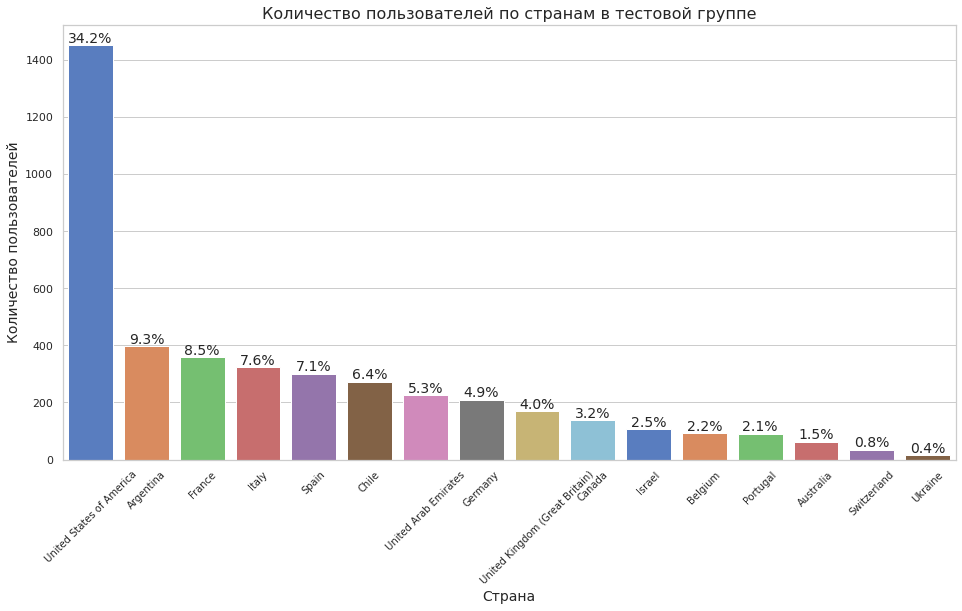

In [22]:
# Устанавим стиль графиков
sns.set(style="whitegrid")

# Создадим столбчатую диаграмму
plt.figure(figsize=(16, 8))
barplot=sns.barplot(x=filtred_users_test_by_countries.index, y=filtred_users_test_by_countries.values, palette='muted')

# Добавим заголовок и метки осей
plt.title('Количество пользователей по странам в тестовой группе', fontsize=16)
plt.xlabel('Страна', fontsize=14)
plt.ylabel('Количество пользователей', fontsize=14)

# Перевернем подписи по оси X
plt.xticks(fontsize=10, rotation=45) 

# Вычислим общее количество пользователей
total_users = filtred_users_test_by_countries.sum()

# Добавим подписи в процентном соотношении
for p in barplot.patches:
    percentage = f'{(p.get_height() / total_users) * 100:.1f}%'  # Вычисляем процент
    barplot.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='bottom', fontsize=14)

# Отобразим график
plt.show()

На этом графике мы видим максимальное количество пользователей из тестовой группы находятся в США (34,2%). Дальше идут Аргентина, Франция, Италия и Испания.

<h3>1.2. EDA users_control_1</h3>

Теперь рассмотрим данные по пользователям из первой контрольной группы.

In [23]:
users_control_1.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892319115,25,435,NaN,United States of America,"1,2,3,4,5,6",0,22,32,982,NaN,NaN,0
1,891248523,29,500,NaN,United States of America,"1,2",1,26,32,12,NaN,NaN,0
2,891670932,33,800,NaN,France,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,NaN,NaN,0
3,891060786,26,0,NaN,Argentina,"1,2,3,4,5",1,23,29,0,NaN,NaN,0
4,892006554,35,294,NaN,United States of America,"1,2,3,5,6,7,8,9,10,12,15,16,17,19",1,30,40,17,NaN,NaN,0


In [24]:
users_control_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4340 non-null   int64  
 1   age               4340 non-null   int64  
 2   attraction_coeff  4340 non-null   int64  
 3   coins             60 non-null     float64
 4   country           4340 non-null   object 
 5   visit_days        3016 non-null   object 
 6   gender            4340 non-null   int64  
 7   age_filter_start  4340 non-null   int64  
 8   age_filter_end    4340 non-null   int64  
 9   views_count       4340 non-null   int64  
 10  was_premium       436 non-null    float64
 11  is_premium        192 non-null    float64
 12  total_revenue     4340 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 440.9+ KB


In [25]:
users_control_1.shape

(4340, 13)

Опять видим пропущенные значения в столбцах coins (внутренняя валюта), что нормально, у пользователя может не быть монеток, также значения пропущены в стобцах visit_days, was_premium, is_premium. Пропуски в тех же столбцах, что и в тестовой группе. 

Заменим пропуски на 0 во всей таблице

In [26]:
users_control_1=users_control_1.fillna(0)

In [27]:
users_control_1.isna().sum()

uid                 0
age                 0
attraction_coeff    0
coins               0
country             0
visit_days          0
gender              0
age_filter_start    0
age_filter_end      0
views_count         0
was_premium         0
is_premium          0
total_revenue       0
dtype: int64

In [28]:
users_control_1.describe()

,uid,age,attraction_coeff,coins,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
count,4.340000e+03,4340.000000,4340.000000,4340.000000,4340.000000,4340.000000,4340.000000,4340.000000,4340.000000,4340.000000,4340.000000
mean,8.917578e+08,32.095392,312.048848,24.136866,0.958065,26.793779,38.553226,44.467512,0.100461,0.044240,594.761982
std,1.125683e+06,10.257466,320.972130,1518.279250,0.200465,9.405103,15.226951,204.800272,0.300648,0.205651,7987.922925
min,8.910510e+08,16.000000,0.000000,0.000000,0.000000,13.000000,19.000000,0.000000,0.000000,0.000000,0.000000
25%,8.913626e+08,24.000000,0.000000,0.000000,1.000000,19.000000,28.000000,1.000000,0.000000,0.000000,0.000000
50%,8.917272e+08,30.000000,238.500000,0.000000,1.000000,25.000000,35.000000,6.000000,0.000000,0.000000,0.000000
75%,8.920898e+08,38.000000,518.000000,0.000000,1.000000,32.000000,45.000000,21.000000,0.000000,0.000000,0.000000
max,9.609370e+08,99.000000,1000.000000,99958.000000,1.000000,96.000000,102.000000,4953.000000,1.000000,1.000000,486330.000000


In [29]:
(users_control_1.query('is_premium==1').uid.count()/users_control_1.uid.count()*100).round(2)

4.42

In [30]:
(users_control_1.query('was_premium==1').uid.count()/users_control_1.uid.count()*100).round(2)

10.05

In [31]:
total_revenue_control1=users_control_1.total_revenue.sum()
total_revenue_control1

2581267

In [32]:
(total_revenue_control1/total_revenue_test*100).round(2)

112.19

- Количество пользователей первой контрольной группы 4340 (в тестовой =4308).  
- Средний возраст пользователей первой контрольной группы 32 (такой же, как в тестовой), медианный 30 (как в тестовой), минимальный 16 (как в тестовой), максимальный 99 (как в тестовой).  
- Средний коэффициент привлекательности 312 (что на 4 пункта ниже, чем в тестовой), медианный 238,5(на 11,5 пунктов ниже, чем тест), максимальный 1000 (как в тестовой).  
- Премиум-подписка у 4.42% (в тестовой =3,64%).  
- Был когда-либо премимум у 10,05% пользователей (в тестовой =9,47%).   
- Общая сумма выручки в первой контрольной группе равна 2581267 (на 12,19% больше, чем в тестовой).
- Среднее значение выручки 594,76 Максимальное - 486330

Посмотрим у каких пользователей указана премиум-подписка, но нормированная выручка равнв 0

In [33]:
users_control_1_for_check=users_control_1.query('is_premium==0 & was_premium==0 & total_revenue!=0')
users_control_1_for_check

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
5,891497961,28,400,28.0,Chile,"1,2",1,25,31,25,0.0,0.0,6396
532,891960267,27,0,28.0,Italy,0,1,24,30,0,0.0,0.0,3952
644,891792453,18,0,8.0,Australia,"1,2,3,4,5,6,7,8,9,10,11,13,14,15,16",1,18,21,0,0.0,0.0,1313
801,891135642,47,200,1.0,Chile,"1,2,3,4,5,6",1,40,46,165,0.0,0.0,962
1079,892140927,27,0,28.0,France,0,1,24,30,0,0.0,0.0,3965
1756,892104378,32,620,22.0,United States of America,"1,2,3",1,29,35,58,0.0,0.0,4602
2665,891867801,24,444,10.0,Israel,1,1,21,30,9,0.0,0.0,6305
2964,892069554,47,185,8.0,United Kingdom (Great Britain),"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,19,38,1414,0.0,0.0,59267
2998,891653790,24,500,6.0,Italy,"1,2,3,4,5,7,8,9,10,11,12,13,14,15,16",1,29,61,4,0.0,0.0,728
3293,891668241,29,0,28.0,United States of America,0,1,37,50,0,0.0,0.0,6305


Можно предположить, что была ошибка при записе данных. Пока ничего не буду делать с данными записями, позже посмотрим записи по ним в таблице с транзакциями

In [34]:
users_control_1.query('was_premium!=0 & total_revenue==0')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
26,892011666,35,416,0.0,Belgium,"1,2,4,5,6,7,8,10,11,12,13,14,15,16,18,19",1,19,33,12,1.0,0.0,0
48,891366831,36,0,0.0,Spain,"1,2,3,4",1,33,39,0,1.0,0.0,0
54,891641769,22,666,0.0,Belgium,"1,3",1,19,25,3,1.0,0.0,0
65,891100086,35,600,0.0,France,0,1,32,38,5,1.0,1.0,0
118,891709374,41,379,0.0,United States of America,"1,2,3",1,38,44,29,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4295,891062994,46,163,0.0,Switzerland,"1,2,3,4",1,30,40,55,1.0,1.0,0
4300,891303459,25,166,0.0,Italy,"1,2,3,4,5",1,22,30,12,1.0,0.0,0
4307,891070455,24,555,0.0,United Arab Emirates,"1,2,3,4",1,21,27,27,1.0,1.0,0
4330,891664650,45,897,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15",1,18,45,147,1.0,0.0,0


 Странно, что у пользователей стоит статус was_premium и при этом выручка равна нулю.

In [35]:
users_control_1.age.value_counts()

25    227
27    212
26    195
21    186
23    184
30    175
28    170
29    170
22    169
24    165
31    149
32    147
37    132
35    131
34    127
33    125
38    123
20    116
36    104
40     99
19     93
39     88
41     82
16     82
42     78
44     75
43     75
18     74
47     67
46     67
45     67
48     54
49     45
50     42
51     36
52     34
53     31
55     22
17     22
54     22
57     17
59     14
56     12
58     11
99      7
60      4
66      2
61      2
71      2
98      1
91      1
72      1
62      1
73      1
63      1
75      1
Name: age, dtype: int64

In [36]:
users_control_1.query('age>97')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
773,891746646,99,300,0.0,Italy,0,1,50,70,10,0.0,0.0,0
1466,891918399,99,62,0.0,Italy,"1,2,3",1,50,99,16,0.0,0.0,0
1856,891374112,99,900,0.0,United Arab Emirates,"1,2,3,4,5,6,7,8,9,10,11",1,16,99,462,0.0,0.0,0
2103,892185039,99,759,0.0,United Kingdom (Great Britain),"1,2,3,4,5,6,7,8,9",1,43,49,79,1.0,1.0,7332
2238,892321845,99,500,0.0,United States of America,0,1,22,99,4,0.0,0.0,0
2312,891682545,99,0,0.0,United States of America,0,1,96,102,0,0.0,0.0,0
2836,891900387,99,333,0.0,Italy,"1,3,4",1,16,99,3,0.0,0.0,0
2908,892335240,98,593,0.0,United States of America,1,1,22,28,32,0.0,0.0,0


В этой группе также скорее всего возраст 98, 99 был указан по ошибке.

Проверим нет ли ошибок в записе данных, когда коэффициент привлекательности не ноль, но число просмотров 0

In [37]:
users_control_1.nunique()

uid                 4340
age                   56
attraction_coeff     587
coins                 23
country               40
visit_days           881
gender                 2
age_filter_start      53
age_filter_end        78
views_count          339
was_premium            2
is_premium             2
total_revenue        128
dtype: int64

<h3>1.3. EDA users_control_2</h3>

In [38]:
users_control_2.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892035504,37,137,NaN,Israel,"1,2,3,4,5,6,7,8,9,11,13",1,30,40,51,NaN,NaN,0
1,891782112,57,0,NaN,Italy,1,1,54,60,0,NaN,NaN,0
2,891110337,30,769,NaN,France,"1,2,3,4,5",1,27,33,13,NaN,NaN,0
3,891796320,48,750,NaN,France,"1,4,6,8,10,11,12,14,15,16,18",1,45,51,12,NaN,NaN,0
4,891880212,54,638,NaN,United States of America,1,1,35,53,94,NaN,NaN,0


In [39]:
users_control_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4264 entries, 0 to 4263
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4264 non-null   int64  
 1   age               4264 non-null   int64  
 2   attraction_coeff  4264 non-null   int64  
 3   coins             61 non-null     float64
 4   country           4264 non-null   object 
 5   visit_days        2900 non-null   object 
 6   gender            4264 non-null   int64  
 7   age_filter_start  4264 non-null   int64  
 8   age_filter_end    4264 non-null   int64  
 9   views_count       4264 non-null   int64  
 10  was_premium       411 non-null    float64
 11  is_premium        191 non-null    float64
 12  total_revenue     4264 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 433.2+ KB


In [40]:
users_control_2.shape

(4264, 13)

Заменим пропущеные значения во всей таблице на 0

In [41]:
users_control_2=users_control_2.fillna(0)

In [42]:
users_control_2.isna().sum()

uid                 0
age                 0
attraction_coeff    0
coins               0
country             0
visit_days          0
gender              0
age_filter_start    0
age_filter_end      0
views_count         0
was_premium         0
is_premium          0
total_revenue       0
dtype: int64

In [43]:
users_control_2.describe()

,uid,age,attraction_coeff,coins,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
count,4.264000e+03,4264.000000,4264.000000,4264.000000,4264.000000,4264.000000,4264.000000,4264.000000,4264.000000,4264.000000,4264.000000
mean,8.917694e+08,32.046201,317.957317,0.259615,0.954268,26.954268,38.906895,45.064493,0.096388,0.044794,450.384146
std,2.520759e+06,10.170721,326.191737,4.724639,0.208927,9.546657,15.955574,318.188992,0.295158,0.206875,2859.242228
min,8.910509e+08,16.000000,0.000000,0.000000,0.000000,13.000000,19.000000,0.000000,0.000000,0.000000,0.000000
25%,8.913453e+08,25.000000,0.000000,0.000000,1.000000,19.000000,28.000000,1.000000,0.000000,0.000000,0.000000
50%,8.917205e+08,30.000000,250.000000,0.000000,1.000000,25.000000,35.000000,6.000000,0.000000,0.000000,0.000000
75%,8.920735e+08,38.000000,548.500000,0.000000,1.000000,32.000000,45.000000,20.000000,0.000000,0.000000,0.000000
max,1.053059e+09,99.000000,1000.000000,271.000000,1.000000,94.000000,99.000000,16157.000000,1.000000,1.000000,81796.000000


In [44]:
(users_control_2.query('is_premium==1').uid.count()/users_control_2.uid.count()*100).round(2)

4.48

In [45]:
(users_control_2.query('was_premium==1').uid.count()/users_control_2.uid.count()*100).round(2)

9.64

In [46]:
total_revenue_control2=users_control_2.total_revenue.sum()
total_revenue_control2

1920438

In [47]:
(100-total_revenue_control2/total_revenue_test*100).round(2)

16.53

In [48]:
(100-total_revenue_control2/total_revenue_control1*100).round(2)

25.6

- Количество пользователей второй контрольной группы 4264(в тестовой =4308, контроль1=4340). 
- Средний возраст пользователей второй контрольной группы 32 (такой же, как в тестовой и первой контрольной), медианный 30 (как в тестовой, контроль1), минимальный 16 (как в тестовойи в контрол1), максимальный 99 (как в тестовой и в контроль1). - Средний коэффициент привлекательности 318 (что на 2 пункта выше, чем в тесте и на 6 пунктов выше, чем в контролб1), медианный 250 (как в тестовой, на 11,5 пунктов выше, чем контроль1), максимальный 1000 (как в тестовой и в контроль1).
- Премиум-подписка у 4.48% пользователей (в тестовой =3,64%, контроль1 =4,42%).
- Был когда-либо премимум у 9,64% пользователей (в тестовой =9,47%, контроль1 =10,05%). 
- Общая сумма выручки во второй контрольной группе равна 1920438 (на 16,53% меньше, чем в тестовой и на 25,6% меньше, чем в контроль1).
- Среднее значение выручки 450,38 максимальное - 81796. 

Посмотрим у каких пользователей указана премиум-подписка, но нормированная выручка равнв 0

In [49]:
users_control_2_for_check=users_control_2.query('is_premium==0 & was_premium==0 & total_revenue!=0')
users_control_2_for_check

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
5,892197879,28,71,0.0,Italy,1,1,25,31,14,0.0,0.0,2522
643,892009254,21,0,0.0,Italy,"1,3,4,5,6,7",1,18,24,0,0.0,0.0,7072
765,891317289,29,333,2.0,Chile,"1,2,3,4,5,6,7,8",1,21,32,12,0.0,0.0,481
855,891232197,32,243,1.0,Italy,"1,2",1,29,35,82,0.0,0.0,3900
1044,891662685,39,272,0.0,France,11,1,36,42,11,0.0,0.0,2717
1720,892345869,23,1000,0.0,Chile,1,1,20,26,4,0.0,0.0,2457
1781,891841752,22,541,0.0,United States of America,"1,2,3,4,5,6,7,10,11,12,13,14,15,16,18",1,19,25,179,0.0,0.0,1586
1833,891260820,24,318,0.0,United States of America,"1,2,3,4,5,6,7,8,9",1,21,27,22,0.0,0.0,897
2408,892069761,16,90,16.0,Argentina,"1,2,3",1,16,20,11,0.0,0.0,6305
3874,891750606,46,395,4.0,France,"1,2,3,4,5,6,7,8,9,10,11,12,13,15,16",1,43,49,291,0.0,0.0,7813


Пока ничего не буду делать с данными записями, потом посмотрим записи по ним в таблице с транзакциями

In [50]:
users_control_2.query('was_premium!=0 & total_revenue==0')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
27,891958227,31,365,0.0,United States of America,"1,2,3,4,5,7,8,9,11,12,13",1,28,34,63,1.0,0.0,0
34,892235217,49,417,0.0,United States of America,1,1,46,52,79,1.0,0.0,0
52,891293337,34,530,0.0,United States of America,"1,2,3,4,5,7",1,31,37,49,1.0,0.0,0
66,892363275,39,500,0.0,Germany,0,1,36,42,12,1.0,0.0,0
74,891996033,27,166,0.0,Argentina,0,1,24,30,6,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4186,891097317,29,1000,0.0,Canada,0,1,26,32,1,1.0,1.0,0
4191,891055815,24,0,0.0,Portugal,1,1,21,27,0,1.0,1.0,0
4204,891817071,28,0,0.0,France,1,1,25,31,0,1.0,0.0,0
4211,891333783,31,642,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10",1,27,40,109,1.0,0.0,0


Сранно, что у пользователей стоит статус was_premium и при этом выручка равна нулю.

In [51]:
users_control_2.age.value_counts()

25    241
27    226
24    189
26    185
29    173
21    171
22    169
31    168
30    167
28    165
32    165
34    153
23    149
35    117
20    115
40    114
33    108
37    107
19     94
36     92
41     91
38     87
16     87
39     81
42     80
43     77
18     74
44     65
46     64
48     52
45     51
49     50
47     50
51     36
50     35
54     32
52     30
55     28
53     26
56     19
57     14
59     13
60     12
58     11
17      9
70      3
63      3
61      3
99      2
66      2
64      1
92      1
78      1
65      1
73      1
77      1
87      1
67      1
90      1
Name: age, dtype: int64

In [52]:
users_control_2.query('age>97')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
1100,891995541,99,213,0.0,Ukraine,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,18,99,197,1.0,1.0,8879
2571,891559305,99,440,0.0,Germany,"1,2",0,24,37,25,0.0,0.0,0


Проверим нет ли ошибок в записе данных, когда коэффициент привлекательности не ноль, но число просмотров 0.


In [53]:
users_control_2.query('attraction_coeff>0 & views_count==0')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue


In [54]:
users_control_2.nunique()

uid                 4264
age                   59
attraction_coeff     585
coins                 24
country               45
visit_days           838
gender                 2
age_filter_start      56
age_filter_end        79
views_count          328
was_premium            2
is_premium             2
total_revenue        128
dtype: int64

Так как A/B тест был проведен для пользователей из нескольких стран, оставим во всех таблицах только пользователей из стран, которые есть в тестовой группе (users_test).

In [55]:
users_control_1 = users_control_1[users_control_1['country'].isin(users_test['country'])]
users_control_2 = users_control_2[users_control_2['country'].isin(users_test['country'])]
transactions_control_1 = transactions_control_1[transactions_control_1['country'].isin(users_test['country'])]
transactions_control_2 = transactions_control_2[transactions_control_2['country'].isin(users_test['country'])]

Посмотрим как распределились пользователи по странам в каждой из групп.

In [56]:
users_test_countries = users_test['country'].value_counts()
users_test_countries_flt = users_test_countries[users_test_countries>7].sort_values(ascending=False)    
users_control_1_countries = users_control_1['country'].value_counts()
users_control_1_countries_flt = users_control_1_countries[users_control_1_countries>7].sort_values(ascending=False)   
users_control_2_countries = users_control_2['country'].value_counts()
users_control_2_countries_flt = users_control_2_countries[users_control_2_countries>7].sort_values(ascending=False)   

In [57]:
df_all_users = pd.DataFrame({
    'test_users': users_test_countries_flt,
    'control_1_users': users_control_1_countries_flt,
    'control_2_users': users_control_2_countries_flt
})
df_all_users=df_all_users.reset_index().rename(columns={'index':'country'})

In [58]:
df_all_users_2 = df_all_users.melt(id_vars='country', var_name='Group', value_name='Users').sort_values(by='Users',ascending=False)
df_all_users_2

,country,Group,Users
53,United States of America,control_2_users,1486.0
35,United States of America,control_1_users,1471.0
17,United States of America,test_users,1450.0
36,Argentina,control_2_users,397.0
0,Argentina,test_users,396.0
18,Argentina,control_1_users,389.0
41,France,control_2_users,376.0
23,France,control_1_users,370.0
5,France,test_users,359.0
29,Spain,control_1_users,342.0


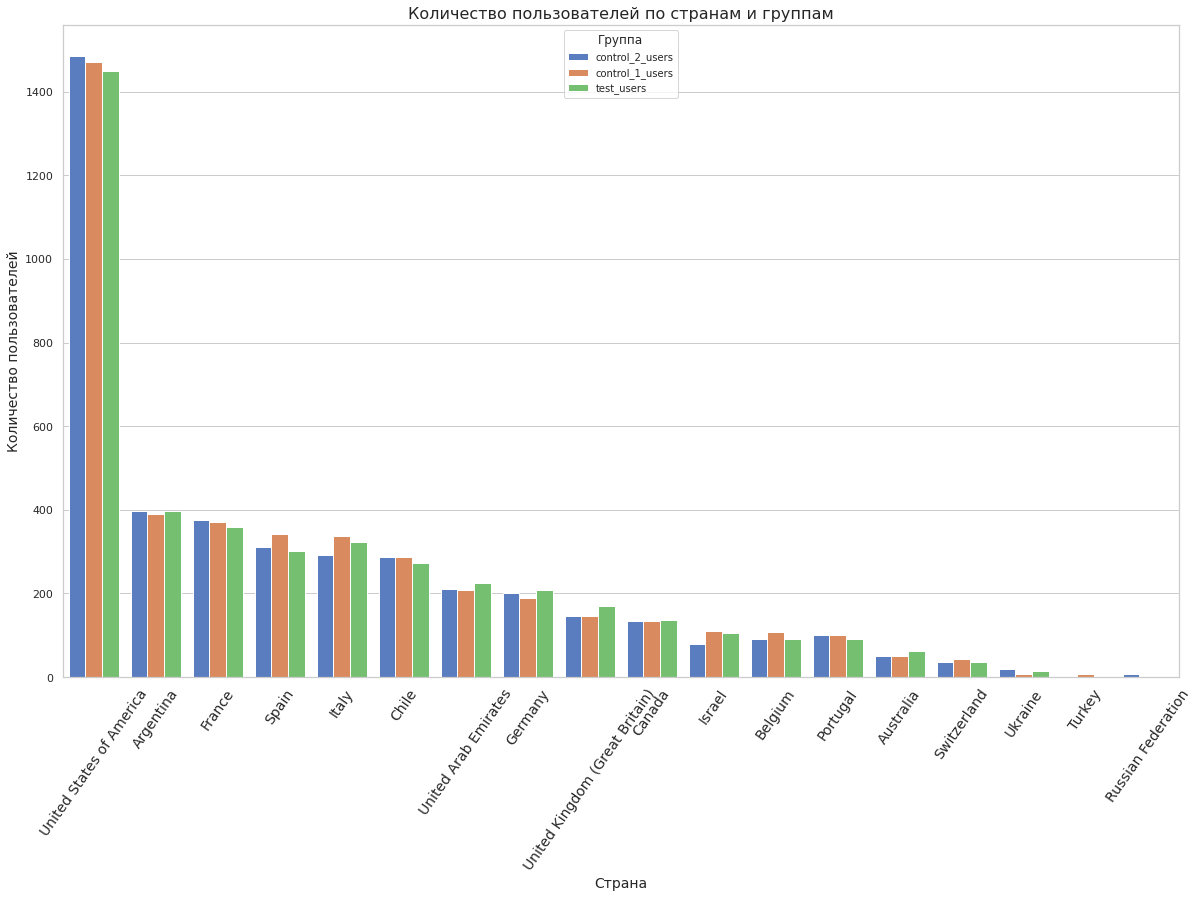

In [59]:
# Установим стиль графика
sns.set(style="whitegrid")

# Создадим барплот
plt.figure(figsize=(20, 12))
bar_plot1 = sns.barplot(data=df_all_users_2, x='country', y='Users', hue='Group', palette='muted')

# Добавим заголовок и метки осей
plt.title('Количество пользователей по странам и группам', fontsize=16)
plt.xlabel('Страна', fontsize=14)
plt.ylabel('Количество пользователей', fontsize=14)

# Перевернем подписи по оси X
plt.xticks(fontsize=14, rotation=55) 

# Вычислим общее количество пользователей
total_users_2 = df_all_users_2.Users.sum()

# Выведем график
# Показываем график
plt.legend(title = 'Группа', fontsize = 10)
plt.show()

На этом графике видно, что большая часть пользователей во всех трех группах из Америки, дальше по количеству пользователей входят Аргентина, Франция, Испания и Италия.

Теперь добавим колонгу Group во все таблицы.

In [60]:
users_test['group']='test'
users_control_1['group']='control_1'
users_control_2['group']='control_2'

Теперь сделаем объединение всех таблиц для упрощения дальнейшего анализа.

In [61]:
full_group_users = pd.concat([users_test, users_control_1, users_control_2], axis=0)
full_group_users

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group
0,892309896,27,685,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,0.0,0.0,0,test
1,892044516,27,0,0.0,Germany,0,1,24,30,0,0.0,0.0,0,test
2,892185708,45,44,0.0,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,0.0,0.0,0,test
3,892130292,32,0,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,0.0,0.0,0,test
4,891406035,27,1000,0.0,France,0,1,24,30,1,1.0,0.0,0,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4259,891937401,63,242,0.0,Italy,"1,2",1,50,66,33,0.0,0.0,0,control_2
4260,891692844,35,500,0.0,France,"1,2,3,4,5,6,8,9,10,11,12,14,16",1,24,45,2,0.0,0.0,0,control_2
4261,891096429,41,333,0.0,United States of America,0,1,38,44,6,0.0,0.0,0,control_2
4262,891697584,48,210,0.0,United Kingdom (Great Britain),"2,3,5,7,9,10,12,14,15",1,45,51,19,0.0,0.0,0,control_2


In [62]:
full_group_users.shape

(12887, 14)

Теперь рассмотрим распределение пользователей по возрасту во всех 3 группах.

In [63]:
full_group_users_age=full_group_users.groupby(['age','group'], as_index=False).uid.nunique().rename(columns={'uid':'users'})
full_group_users_age=full_group_users_age.query('users>7')

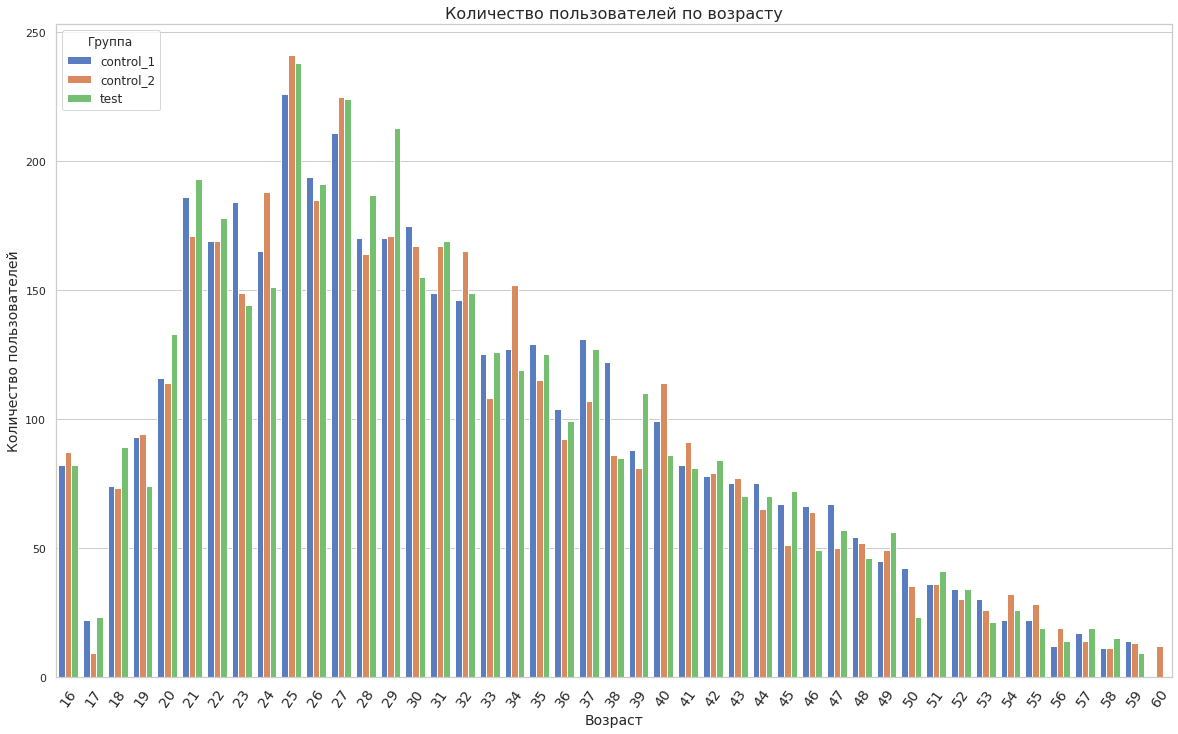

In [64]:
# Установим стиль графика
sns.set(style="whitegrid")

# Создадим барплот
plt.figure(figsize=(20, 12))
sns.barplot(data=full_group_users_age, x='age', y='users', hue='group', palette='muted')

# Добавим заголовок и метки осей
plt.title('Количество пользователей по возрасту', fontsize=16)
plt.xlabel('Возраст', fontsize=14)
plt.ylabel('Количество пользователей', fontsize=14)

# Перевернем подписи по оси X
plt.xticks(fontsize=14, rotation=55) 

# Покажем легенду
plt.legend(title='Группа', fontsize=12)

# Покажим график
plt.show()

Посмотрим на соотношение количества пользователейво всех группах по полу.

In [65]:
full_group_users_gender=full_group_users.groupby(['gender','group'], as_index=False).uid.nunique().rename(columns={'uid':'users'})
full_group_users_gender

,gender,group,users
0,0,control_1,182
1,0,control_2,194
2,0,test,202
3,1,control_1,4148
4,1,control_2,4055
5,1,test,4106


Можно заметить, что по статистике большинство пользователей дейтинговых приложений это мужчины, поэтому будем считать, что 0 это мужчины, а 1 это женщины. Исходя из данных таблицы можно отметить, что во всех трех группах количество мужчин значительно больше, чем женщин.

Теперь проверим, что польлзователи из каждых групп не пересекались между собой.

In [66]:
users_test_copy = users_test.copy()
users_control_1_copy = users_control_1.copy()
users_control_2_copy = users_control_2.copy()

In [67]:
print(users_test_copy.shape)
print(users_control_1_copy.shape)
print(users_control_2_copy.shape)

(4308, 14)
(4330, 14)
(4249, 14)


Сделаем проверку наличия идентификаторов из группы users_test в группе users_control_1.

In [68]:
users_test_copy['exists_test_in_control1'] = users_test_copy['uid'].isin(users_control_1_copy['uid'])
print("\nРезультат проверки:")
users_test_copy['exists_test_in_control1'].value_counts()


Результат проверки:


False    4308
Name: exists_test_in_control1, dtype: int64

Сделаем проверку наличия идентификаторов из группы users_test в группе users_control_2.

In [69]:
users_test_copy['exists_test_in_control2'] = users_test_copy['uid'].isin(users_control_2_copy['uid'])
print("\nРезультат проверки:")
users_test_copy['exists_test_in_control2'].value_counts()


Результат проверки:


False    4308
Name: exists_test_in_control2, dtype: int64

Сделаем проверку наличия идентификаторов из группы users_control_1 в группе users_control_2.

In [70]:
users_control_1_copy['exists_control1_in_control2'] = users_control_1_copy['uid'].isin(users_control_2_copy['uid'])
print("\nРезультат проверки:")
users_control_1_copy['exists_control1_in_control2'].value_counts()


Результат проверки:


False    4330
Name: exists_control1_in_control2, dtype: int64

На основании полученных данных можно сделать вывод о том, что все пользователи из каждой группы уникальны и не встречаются в других группах.

<h2>2. EDA транзакций </h2>

<h3>2.1. EDA transactions_test</h3>

Посмотрим на данные транзакций.

In [71]:
transactions_test.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
4,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087,147,trial_vip_popup,trial_premium


In [73]:
transactions_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   uid           273 non-null    int64 
 1   country       273 non-null    object
 2   joined_at     273 non-null    object
 3   paid_at       273 non-null    object
 4   revenue       273 non-null    int64 
 5   payment_id    273 non-null    int64 
 6   from_page     273 non-null    object
 7   product_type  273 non-null    object
dtypes: int64(3), object(5)
memory usage: 17.2+ KB


Тут видно что в столбцах с датами указан формат object. Преобразуем его в формат даты и времени.

In [72]:
transactions_test['joined_at'] = pd.to_datetime(transactions_test['joined_at'])
transactions_test['paid_at'] = pd.to_datetime(transactions_test['paid_at'])

Сделаем проверку.

In [73]:
transactions_test.dtypes

uid                      int64
country                 object
joined_at       datetime64[ns]
paid_at         datetime64[ns]
revenue                  int64
payment_id               int64
from_page               object
product_type            object
dtype: object

In [74]:
transactions_test.shape

(273, 8)

In [75]:
transactions_test.nunique()

uid             146
country          17
joined_at       146
paid_at         258
revenue         125
payment_id        6
from_page        22
product_type      4
dtype: int64

Сделаем проверку на дубликаты данным и удалим их.

In [76]:
duplicates = transactions_test[transactions_test.duplicated()]
duplicates 

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
55,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
96,892050108,Israel,2017-10-22 03:02:00,2017-10-23 02:53:00,1261,19,empty_likes,coins
127,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
158,891508155,Latvia,2017-02-11 09:46:00,2017-03-11 22:06:00,936,19,empty_likes,coins
188,892236423,United States of America,2017-10-18 01:09:00,2017-10-22 22:08:00,1261,19,empty_likes,coins
205,892202526,United States of America,2017-10-18 20:34:00,2017-10-20 19:54:00,897,19,menu,coins
243,892339626,United States of America,2017-10-15 23:21:00,2017-10-20 18:14:00,754,19,empty_likes,coins


In [77]:
transactions_test = transactions_test.drop_duplicates()

In [78]:
transactions_test.shape

(266, 8)

Теперь можем посмотреть на количество транзакций по типу продукта.

In [79]:
transactions_test.product_type.value_counts()

coins               101
premium_no_trial     76
trial_premium        62
other_type           27
Name: product_type, dtype: int64

Видим, что большинство опреаций совершается за монетки (внутреннюю валюту).

В задании нам сказали, об изменении стоимости премиум-подписки через 2 новые платежные системы. Стоит отметить, что единственная графа, которая может обозначать платежную систему это payment_id.

Посмотрюим на количество транзакций с типом премиум-подписка без пробной в разрезе платежных систем.

In [80]:
transactions_test.query('product_type=="premium_no_trial"').payment_id.value_counts()

147    63
68     12
0       1
Name: payment_id, dtype: int64

По полученным данным можно предположить, что новые платежные системы это 147 и 68. Также 0 скорее всего ошибочно записанная транзакция и мы можем ее удалить.

In [81]:
transactions_test.query('product_type=="premium_no_trial" & payment_id==0')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
220,891725043,United Arab Emirates,2017-10-29 00:49:00,2017-10-29 07:48:00,9217,0,none,premium_no_trial


In [82]:
transactions_test=transactions_test.drop(index = 220)
transactions_test.shape

(265, 8)

In [83]:
users_test.query('uid==891725043')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group
2935,891725043,28,282,0.0,United Arab Emirates,"1,2,3,4,5,6,8,9,10,12,13,15,16,17",1,25,31,117,1.0,1.0,18434,test


Теперь удалим записи с платежной системой 0.

In [84]:
users_test=users_test.drop(index = 2935)
users_test.shape

(4307, 14)

In [85]:
transactions_test.joined_at.min()

Timestamp('2017-01-11 03:07:00')

In [86]:
transactions_test.joined_at.max()

Timestamp('2017-10-31 23:40:00')

In [87]:
transactions_test.paid_at.min()

Timestamp('2017-01-11 04:37:00')

In [88]:
transactions_test.paid_at.max()

Timestamp('2017-12-11 22:06:00')

Мы смотрим на дынные временного промежутка проведения А/В теста и видим, что он продолжался почти 11 месяцев.  
Стоит отемтить, что обычная продолжительность А/В теста примерно 2 месяца.  
Возможно здесь есть ошибка. Их нужно проверить.

In [89]:
test_joined_at = transactions_test['joined_at'].sort_values(ascending=False).tolist()
test_joined_at

[Timestamp('2017-10-31 23:40:00'),
 Timestamp('2017-10-31 20:40:00'),
 Timestamp('2017-10-31 14:16:00'),
 Timestamp('2017-10-31 14:16:00'),
 Timestamp('2017-10-31 14:16:00'),
 Timestamp('2017-10-31 14:16:00'),
 Timestamp('2017-10-31 14:16:00'),
 Timestamp('2017-10-31 08:41:00'),
 Timestamp('2017-10-31 08:41:00'),
 Timestamp('2017-10-31 08:41:00'),
 Timestamp('2017-10-31 06:36:00'),
 Timestamp('2017-10-31 06:36:00'),
 Timestamp('2017-10-31 05:09:00'),
 Timestamp('2017-10-30 23:01:00'),
 Timestamp('2017-10-30 17:14:00'),
 Timestamp('2017-10-30 13:47:00'),
 Timestamp('2017-10-30 07:50:00'),
 Timestamp('2017-10-30 06:05:00'),
 Timestamp('2017-10-30 05:59:00'),
 Timestamp('2017-10-30 05:59:00'),
 Timestamp('2017-10-30 05:59:00'),
 Timestamp('2017-10-29 15:40:00'),
 Timestamp('2017-10-29 13:19:00'),
 Timestamp('2017-10-29 08:03:00'),
 Timestamp('2017-10-29 05:42:00'),
 Timestamp('2017-10-29 00:49:00'),
 Timestamp('2017-10-28 06:09:00'),
 Timestamp('2017-10-28 06:09:00'),
 Timestamp('2017-10-

In [90]:
test_paid_at = transactions_test['paid_at'].sort_values(ascending=False).tolist()
test_paid_at

[Timestamp('2017-12-11 22:06:00'),
 Timestamp('2017-12-11 21:20:00'),
 Timestamp('2017-12-11 17:26:00'),
 Timestamp('2017-12-11 16:34:00'),
 Timestamp('2017-12-11 16:05:00'),
 Timestamp('2017-12-11 08:25:00'),
 Timestamp('2017-12-11 02:11:00'),
 Timestamp('2017-12-11 02:10:00'),
 Timestamp('2017-12-11 00:11:00'),
 Timestamp('2017-11-15 09:31:00'),
 Timestamp('2017-11-15 04:33:00'),
 Timestamp('2017-11-14 11:22:00'),
 Timestamp('2017-11-14 09:47:00'),
 Timestamp('2017-11-14 09:45:00'),
 Timestamp('2017-11-14 09:16:00'),
 Timestamp('2017-11-14 04:37:00'),
 Timestamp('2017-11-14 04:33:00'),
 Timestamp('2017-11-14 04:33:00'),
 Timestamp('2017-11-14 03:39:00'),
 Timestamp('2017-11-14 01:57:00'),
 Timestamp('2017-11-14 01:12:00'),
 Timestamp('2017-11-13 15:04:00'),
 Timestamp('2017-11-13 11:21:00'),
 Timestamp('2017-11-13 05:58:00'),
 Timestamp('2017-11-13 03:46:00'),
 Timestamp('2017-11-13 03:42:00'),
 Timestamp('2017-11-13 00:52:00'),
 Timestamp('2017-11-11 23:51:00'),
 Timestamp('2017-11-

Исходя изполученных данных эксперимент длился с 2017-10-14 по 2017-11-15.  
В графе joined_at в ноябре даты записаны некорректно: число перепутано местами с месяцем.  
В графе paid_at с 2017-10-14 по 2017-10-31 и далее с 2017-11-13 по 2017-11-15 записаны корректно.   
Видим, что в данных с 2017-11-01 по 2017-11-12  число перепутано местами с месяцем.

Теперь создадим функцию, внутри которой создададим маску для определения строк, в которых число = 11.


In [91]:
def replace_day_with_month(df, date_column):
    # Заменим день на месяц, если число = 11
    mask = df[date_column].dt.day == 11
    df.loc[mask, date_column] = df.loc[mask, date_column].apply(lambda x: x.replace(day=x.month, month=11))

# Применим функцию 
for df in [transactions_test]:
    replace_day_with_month(df, 'joined_at')
    replace_day_with_month(df, 'paid_at')

Сделаем проверку работы нащей функии к нашим датам.

In [92]:
transactions_test['joined_at'].sort_values(ascending=False).tolist()

[Timestamp('2017-11-10 10:20:00'),
 Timestamp('2017-11-08 18:39:00'),
 Timestamp('2017-11-08 07:24:00'),
 Timestamp('2017-11-08 07:24:00'),
 Timestamp('2017-11-08 07:24:00'),
 Timestamp('2017-11-08 07:24:00'),
 Timestamp('2017-11-08 07:24:00'),
 Timestamp('2017-11-08 07:24:00'),
 Timestamp('2017-11-08 06:41:00'),
 Timestamp('2017-11-08 03:54:00'),
 Timestamp('2017-11-08 03:54:00'),
 Timestamp('2017-11-08 03:54:00'),
 Timestamp('2017-11-07 09:26:00'),
 Timestamp('2017-11-07 09:26:00'),
 Timestamp('2017-11-07 08:52:00'),
 Timestamp('2017-11-07 07:02:00'),
 Timestamp('2017-11-07 03:39:00'),
 Timestamp('2017-11-07 02:37:00'),
 Timestamp('2017-11-07 01:38:00'),
 Timestamp('2017-11-06 23:56:00'),
 Timestamp('2017-11-06 23:12:00'),
 Timestamp('2017-11-06 22:47:00'),
 Timestamp('2017-11-06 22:47:00'),
 Timestamp('2017-11-06 09:33:00'),
 Timestamp('2017-11-06 09:33:00'),
 Timestamp('2017-11-06 09:21:00'),
 Timestamp('2017-11-06 04:34:00'),
 Timestamp('2017-11-06 01:35:00'),
 Timestamp('2017-11-

In [93]:
transactions_test['paid_at'].sort_values(ascending=False).tolist()

[Timestamp('2017-11-15 09:31:00'),
 Timestamp('2017-11-15 04:33:00'),
 Timestamp('2017-11-14 11:22:00'),
 Timestamp('2017-11-14 09:47:00'),
 Timestamp('2017-11-14 09:45:00'),
 Timestamp('2017-11-14 09:16:00'),
 Timestamp('2017-11-14 04:37:00'),
 Timestamp('2017-11-14 04:33:00'),
 Timestamp('2017-11-14 04:33:00'),
 Timestamp('2017-11-14 03:39:00'),
 Timestamp('2017-11-14 01:57:00'),
 Timestamp('2017-11-14 01:12:00'),
 Timestamp('2017-11-13 15:04:00'),
 Timestamp('2017-11-13 11:21:00'),
 Timestamp('2017-11-13 05:58:00'),
 Timestamp('2017-11-13 03:46:00'),
 Timestamp('2017-11-13 03:42:00'),
 Timestamp('2017-11-13 00:52:00'),
 Timestamp('2017-11-12 22:06:00'),
 Timestamp('2017-11-12 21:20:00'),
 Timestamp('2017-11-12 17:26:00'),
 Timestamp('2017-11-12 16:34:00'),
 Timestamp('2017-11-12 16:05:00'),
 Timestamp('2017-11-12 08:25:00'),
 Timestamp('2017-11-12 02:11:00'),
 Timestamp('2017-11-12 02:10:00'),
 Timestamp('2017-11-12 00:11:00'),
 Timestamp('2017-11-11 23:51:00'),
 Timestamp('2017-11-

In [94]:
min_joined_at_test = transactions_test.joined_at.min()
max_joined_at_test = transactions_test.joined_at.max()
min_paid_at_test = transactions_test.paid_at.min()
max_paid_at_test = transactions_test.paid_at.max()

# Выведем результаты
print(f"Минимальная дата 'joined_at': {min_joined_at_test}")
print(f"Максимальная дата 'joined_at': {max_joined_at_test}")
print(f"Минимальная дата 'paid_at': {min_paid_at_test}")
print(f"Максимальная дата 'paid_at': {max_paid_at_test}")

Минимальная дата 'joined_at': 2017-10-14 00:58:00
Максимальная дата 'joined_at': 2017-11-10 10:20:00
Минимальная дата 'paid_at': 2017-10-14 04:23:00
Максимальная дата 'paid_at': 2017-11-15 09:31:00


Теперь мы видим более достоверные показатели о длительности эксперимента. Получается месяц.

Сделаем проверку записей, у которым время регистрации больше, чем время оплаты.

In [95]:
transactions_test.query('joined_at>paid_at')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type


In [96]:
transactions_test.dtypes

uid                      int64
country                 object
joined_at       datetime64[ns]
paid_at         datetime64[ns]
revenue                  int64
payment_id               int64
from_page               object
product_type            object
dtype: object

In [97]:
transactions_test.revenue.sum()

2323009

In [98]:
users_test_for_check_2.shape

(6, 13)

Сделаем проверку пользователей из данных о пользователях, которых нужно проверить (выручка не 0, но указано, что пользователи не являются премиумом и никогда им не были).

In [99]:
test_full_data_check_2=pd.merge(users_test_for_check_2, transactions_test, on='uid', how='left')
test_full_data_check_2

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,892333656,50,436,4.0,United States of America,"1,2,3,4",1,47,53,126,0.0,0.0,897,United States of America,2017-10-16 01:45:00,2017-10-16 01:49:00,897,146,empty_likes,coins
1,891914511,30,500,4.0,Switzerland,1,1,18,43,2,0.0,0.0,1508,Switzerland,2017-10-24 23:15:00,2017-10-25 03:21:00,1508,146,empty_likes,coins
2,891914322,35,500,6.0,United States of America,"1,2,3,4,5,6,7,8,9",1,32,38,48,0.0,0.0,741,United States of America,2017-10-24 23:20:00,2017-10-24 23:23:00,741,146,menu,coins
3,891999783,30,793,6.0,United States of America,"1,2,4,5,6,8,9,10,11,12,13,14,15,16,17,18,19,20...",1,27,33,29,0.0,0.0,3783,United States of America,2017-10-23 04:21:00,2017-10-23 06:13:00,1261,19,autorefill,coins
4,891999783,30,793,6.0,United States of America,"1,2,4,5,6,8,9,10,11,12,13,14,15,16,17,18,19,20...",1,27,33,29,0.0,0.0,3783,United States of America,2017-10-23 04:21:00,2017-10-23 06:12:00,1261,19,empty_likes,coins
5,891999783,30,793,6.0,United States of America,"1,2,4,5,6,8,9,10,11,12,13,14,15,16,17,18,19,20...",1,27,33,29,0.0,0.0,3783,United States of America,2017-10-23 04:21:00,2017-10-23 06:11:00,1261,19,empty_likes,coins
6,891632079,30,100,9.0,United States of America,"5,6",1,27,33,20,0.0,0.0,4537,United States of America,2017-10-30 17:14:00,2017-10-30 22:04:00,4537,19,sympathy,other_type
7,891175326,29,666,6.0,United States of America,"1,2,3,5,7",1,26,32,3,0.0,0.0,897,United States of America,2017-11-08 06:41:00,2017-11-09 04:33:00,897,146,empty_likes,coins


In [100]:
test_full_data_check_2.isna().sum()

uid                 0
age                 0
attraction_coeff    0
coins               0
country_x           0
visit_days          0
gender              0
age_filter_start    0
age_filter_end      0
views_count         0
was_premium         0
is_premium          0
total_revenue       0
country_y           0
joined_at           0
paid_at             0
revenue             0
payment_id          0
from_page           0
product_type        0
dtype: int64

Как мы видим по записям из таблицы транзакций, покупка была либо за внутреннюю валюту, либо другой тип. Так как невозможно точно установить являются ли пользователи премиум либо когда-то были премиумом, удалим эти записи из таблицы users_test и transactions_test.

In [101]:
transactions_test.query('uid==[892333656,891914511,891914322,891999783,891632079,891175326]')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
8,891999783,United States of America,2017-10-23 04:21:00,2017-10-23 06:13:00,1261,19,autorefill,coins
65,891999783,United States of America,2017-10-23 04:21:00,2017-10-23 06:12:00,1261,19,empty_likes,coins
75,891175326,United States of America,2017-11-08 06:41:00,2017-11-09 04:33:00,897,146,empty_likes,coins
116,891632079,United States of America,2017-10-30 17:14:00,2017-10-30 22:04:00,4537,19,sympathy,other_type
142,891914511,Switzerland,2017-10-24 23:15:00,2017-10-25 03:21:00,1508,146,empty_likes,coins
156,891914322,United States of America,2017-10-24 23:20:00,2017-10-24 23:23:00,741,146,menu,coins
157,891999783,United States of America,2017-10-23 04:21:00,2017-10-23 06:11:00,1261,19,empty_likes,coins
261,892333656,United States of America,2017-10-16 01:45:00,2017-10-16 01:49:00,897,146,empty_likes,coins


In [102]:
transactions_test=transactions_test.drop(index=[8,65,75,116,142,156,157,261])
transactions_test.shape

(257, 8)

Теперь найдем индексы записей для удаления и удалим их.

In [103]:
indexes_to_drop=users_test.query('is_premium==0 & was_premium==0 & total_revenue!=0').index
users_test.drop(indexes_to_drop, inplace=True)
users_test.shape

(4301, 14)

<h3>2.2. EDA transactions_control_1</h3>

In [104]:
transactions_control_1.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891319275.0,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium
1,892421826.0,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium
2,891822480.0,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911.0,19.0,none,coins
3,891367521.0,Italy,2017-05-11 02:37:00,2017-06-11 19:15:00,1456.0,127.0,sympathy,other_type
4,892207959.0,France,2017-10-18 18:30:00,2017-12-11 12:03:00,1261.0,19.0,empty_likes,coins


In [105]:
transactions_control_1.shape

(377, 8)

In [106]:
transactions_control_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 377 entries, 0 to 376
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   uid           377 non-null    float64
 1   country       377 non-null    object 
 2   joined_at     377 non-null    object 
 3   paid_at       377 non-null    object 
 4   revenue       377 non-null    float64
 5   payment_id    377 non-null    float64
 6   from_page     377 non-null    object 
 7   product_type  377 non-null    object 
dtypes: float64(3), object(5)
memory usage: 26.5+ KB


In [107]:
transactions_control_1.isna().sum()

uid             0
country         0
joined_at       0
paid_at         0
revenue         0
payment_id      0
from_page       0
product_type    0
dtype: int64

Снова сделаем преобразование столбцов joined_at и paid_at из формата object в формат даты и времени. А также столбец uid из float64 в int64.

In [108]:
transactions_control_1['joined_at'] = pd.to_datetime(transactions_control_1['joined_at'])
transactions_control_1['paid_at'] = pd.to_datetime(transactions_control_1['paid_at'])

transactions_control_1['uid'] = transactions_control_1['uid'].astype(int)

In [109]:
transactions_control_1.dtypes

uid                      int64
country                 object
joined_at       datetime64[ns]
paid_at         datetime64[ns]
revenue                float64
payment_id             float64
from_page               object
product_type            object
dtype: object

In [110]:
transactions_control_1.nunique()

uid             193
country          18
joined_at       193
paid_at         335
revenue         127
payment_id        7
from_page        25
product_type      4
dtype: int64

Сделаем проверку на наличие дубликатов в записях и удалим их.

In [111]:
transactions_control_1[transactions_control_1.duplicated()]

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
47,892333905,Italy,2017-10-16 01:38:00,2017-10-16 01:44:00,3783.0,67.0,menu,other_type
88,892333905,Italy,2017-10-16 01:38:00,2017-10-16 01:58:00,3783.0,67.0,empty_admins,other_type
93,891367521,Italy,2017-05-11 02:37:00,2017-10-11 01:52:00,1469.0,19.0,sympathy,other_type
169,892333905,Italy,2017-10-16 01:38:00,2017-10-16 01:44:00,3783.0,67.0,menu,other_type
176,892207959,France,2017-10-18 18:30:00,2017-10-22 04:49:00,1261.0,19.0,empty_likes,coins
198,892333905,Italy,2017-10-16 01:38:00,2017-10-16 01:58:00,3783.0,67.0,empty_admins,other_type
206,891739737,United States of America,2017-10-28 18:50:00,2017-11-13 05:34:00,1261.0,19.0,empty_likes,coins
216,891452706,Italy,2017-03-11 14:48:00,2017-11-11 17:21:00,6305.0,19.0,gifts,coins
223,891721851,United States of America,2017-10-29 02:50:00,2017-11-14 04:08:00,897.0,19.0,empty_likes,coins
233,891365490,United States of America,2017-05-11 03:55:00,2017-06-11 00:28:00,1261.0,19.0,empty_likes,coins


In [112]:
transactions_control_1=transactions_control_1.drop_duplicates()

In [113]:
transactions_control_1.shape

(356, 8)

Теперь можем посмотреть на количество транзакций по типу продукта.

In [114]:
transactions_control_1.product_type.value_counts()

coins               137
premium_no_trial    106
trial_premium        67
other_type           46
Name: product_type, dtype: int64

Видим, что обольшинство транзакций совершено за монетки (внутреннюю валюту).

Теперь посмотрим на количество транзакций с типом премиум-подписка без пробной в разрезе платежных систем.

In [115]:
transactions_control_1.query('product_type=="premium_no_trial"').payment_id.value_counts()

147.0    88
68.0     16
0.0       2
Name: payment_id, dtype: int64

Опять видим транзакции с платежной системой 0. Удалим их.

In [116]:
transactions_control_1.query('product_type=="premium_no_trial" & payment_id==0')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
138,891216033,United States of America,2017-07-11 12:33:00,2017-07-11 12:47:00,6292.0,0.0,autoreply_message,premium_no_trial
347,892101909,France,2017-10-21 03:28:00,2017-10-21 03:39:00,6422.0,0.0,none,premium_no_trial


In [117]:
transactions_control_1=transactions_control_1.drop(index = [138,347])

In [118]:
transactions_control_1.shape

(354, 8)

In [119]:
users_control_1.query('uid==[891216033, 892101909]')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group
1215,892101909,25,531,2.0,France,"1,2,3,4,5,6,7,8,9,10,11,12,14,15,17,18,19,21,2...",1,22,28,32,1.0,1.0,14508,control_1
3789,891216033,20,1000,0.0,United States of America,"1,2",1,17,25,2,1.0,1.0,12584,control_1


Теперь удалим записи с платежной системой 0 по индексам.

In [120]:
users_control_1=users_control_1.drop(index = [1215, 3789])

In [121]:
users_control_1.shape

(4328, 14)

Посмотрим на минимальные и максимальные даты в графах joined_at (время регистрации) и paid_at (время оплаты).


In [122]:
print(f"Минимальная дата 'joined_at': {transactions_control_1.joined_at.min()}")
print(f"Максимальная дата 'joined_at': {transactions_control_1.joined_at.max()}")
print(f"Минимальная дата 'paid_at': {transactions_control_1.paid_at.min()}")
print(f"Максимальная дата 'paid_at': {transactions_control_1.paid_at.max()}")

Минимальная дата 'joined_at': 2015-01-19 11:49:00
Максимальная дата 'joined_at': 2017-10-31 22:17:00
Минимальная дата 'paid_at': 2016-12-14 16:16:00
Максимальная дата 'paid_at': 2017-12-11 21:57:00


Рассмотрим внимательное данные по пользователям, которые зарегистрировались в 2015 году и оплатили в 2016.

In [123]:
transactions_control_1.query('joined_at.dt.year==2015')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
65,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:30:00,26.0,0.0,refund_VP,other_type
101,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:35:00,637.0,0.0,refung_AP,other_type
224,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 16:16:00,143.0,0.0,refund_WP,other_type


In [124]:
transactions_control_1.query('paid_at.dt.year==2016')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
65,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:30:00,26.0,0.0,refund_VP,other_type
101,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:35:00,637.0,0.0,refung_AP,other_type
224,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 16:16:00,143.0,0.0,refund_WP,other_type


По полученным данным мы можем видеть одного пользователя который зарегистрировался в 2015 и оплатил только в 2016. Мы можем удалить эти записи из таблицы с пользователями и таблицы с транзакциями.

In [125]:
transactions_control_1=transactions_control_1.drop(index=[65,101,224])
transactions_control_1.shape

(351, 8)

In [126]:
users_control_1.query('uid==960936960')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group
510,960936960,30,4,99958.0,Russian Federation,"1,2,3,4,7,8,9,10,11,14,15,16,17,18,21,22,23,24...",1,26,62,4262,1.0,1.0,26,control_1


In [127]:
users_control_1=users_control_1.drop(index=510)
users_control_1.shape

(4327, 14)

Перепроверим наши минимальные и максимальные даты в графах joined_at (время регистрации) и paid_at (время оплаты).

In [128]:
print(f"Минимальная дата 'joined_at': {transactions_control_1.joined_at.min()}")
print(f"Максимальная дата 'joined_at': {transactions_control_1.joined_at.max()}")
print(f"Минимальная дата 'paid_at': {transactions_control_1.paid_at.min()}")
print(f"Максимальная дата 'paid_at': {transactions_control_1.paid_at.max()}")

Минимальная дата 'joined_at': 2017-01-11 01:06:00
Максимальная дата 'joined_at': 2017-10-31 22:17:00
Минимальная дата 'paid_at': 2017-01-11 02:56:00
Максимальная дата 'paid_at': 2017-12-11 21:57:00


Можно заметить, что эксперимент длился 11 месяцев, аналогично в тестовой группе. Возможно даты опять записаны некорректно и стоит провести преобразования данных.

In [129]:
control_1_joined_at = transactions_control_1['joined_at'].sort_values(ascending=False).tolist()
control_1_joined_at

[Timestamp('2017-10-31 22:17:00'),
 Timestamp('2017-10-31 17:51:00'),
 Timestamp('2017-10-31 16:30:00'),
 Timestamp('2017-10-31 03:34:00'),
 Timestamp('2017-10-31 03:34:00'),
 Timestamp('2017-10-30 23:53:00'),
 Timestamp('2017-10-30 22:57:00'),
 Timestamp('2017-10-30 20:37:00'),
 Timestamp('2017-10-30 11:22:00'),
 Timestamp('2017-10-30 09:48:00'),
 Timestamp('2017-10-30 06:17:00'),
 Timestamp('2017-10-30 00:57:00'),
 Timestamp('2017-10-30 00:57:00'),
 Timestamp('2017-10-29 23:08:00'),
 Timestamp('2017-10-29 22:30:00'),
 Timestamp('2017-10-29 22:06:00'),
 Timestamp('2017-10-29 21:04:00'),
 Timestamp('2017-10-29 20:43:00'),
 Timestamp('2017-10-29 20:43:00'),
 Timestamp('2017-10-29 19:44:00'),
 Timestamp('2017-10-29 15:24:00'),
 Timestamp('2017-10-29 15:24:00'),
 Timestamp('2017-10-29 15:24:00'),
 Timestamp('2017-10-29 15:24:00'),
 Timestamp('2017-10-29 13:38:00'),
 Timestamp('2017-10-29 11:39:00'),
 Timestamp('2017-10-29 10:54:00'),
 Timestamp('2017-10-29 10:54:00'),
 Timestamp('2017-10-

In [130]:
control_1_paid_at = transactions_control_1['paid_at'].sort_values(ascending=False).tolist()
control_1_paid_at

[Timestamp('2017-12-11 21:57:00'),
 Timestamp('2017-12-11 21:24:00'),
 Timestamp('2017-12-11 21:23:00'),
 Timestamp('2017-12-11 20:59:00'),
 Timestamp('2017-12-11 18:52:00'),
 Timestamp('2017-12-11 18:21:00'),
 Timestamp('2017-12-11 15:32:00'),
 Timestamp('2017-12-11 14:30:00'),
 Timestamp('2017-12-11 12:03:00'),
 Timestamp('2017-12-11 11:37:00'),
 Timestamp('2017-12-11 11:05:00'),
 Timestamp('2017-12-11 07:19:00'),
 Timestamp('2017-12-11 06:09:00'),
 Timestamp('2017-12-11 04:54:00'),
 Timestamp('2017-12-11 03:25:00'),
 Timestamp('2017-12-11 03:25:00'),
 Timestamp('2017-12-11 00:14:00'),
 Timestamp('2017-11-15 09:28:00'),
 Timestamp('2017-11-15 09:19:00'),
 Timestamp('2017-11-15 03:41:00'),
 Timestamp('2017-11-14 22:37:00'),
 Timestamp('2017-11-14 22:03:00'),
 Timestamp('2017-11-14 22:02:00'),
 Timestamp('2017-11-14 22:01:00'),
 Timestamp('2017-11-14 16:50:00'),
 Timestamp('2017-11-14 12:52:00'),
 Timestamp('2017-11-14 07:39:00'),
 Timestamp('2017-11-14 04:08:00'),
 Timestamp('2017-11-

Судя по полученным данным эксперимент длился с 2017-10-14 по 2017-11-15.  
В графе joined_at в ноябре даты записаны некорректно: число перепутано местами с месяцем.   
В графе paid_at с 2017-10-14 по 2017-10-31 и далее с 2017-11-13 по 2017-11-15 записаны корректно.   
В данных с 2017-11-01 по 2017-11-12  число перепутано местами с месяцем.

Теперь создадим функцию, внутри которой создададим маску для определения строк, в которых число = 11.

In [131]:
def replace_day_with_month(df, date_column):
    # Заменим день на месяц, если число = 11
    mask = df[date_column].dt.day == 11
    df.loc[mask, date_column] = df.loc[mask, date_column].apply(lambda x: x.replace(day=x.month, month=11))

# Применим функцию 
for df in [transactions_control_1]:
    replace_day_with_month(df, 'joined_at')
    replace_day_with_month(df, 'paid_at')

In [132]:
transactions_control_1['joined_at'].sort_values(ascending=False).tolist()

[Timestamp('2017-11-09 22:48:00'),
 Timestamp('2017-11-09 22:48:00'),
 Timestamp('2017-11-09 22:48:00'),
 Timestamp('2017-11-09 12:24:00'),
 Timestamp('2017-11-09 07:37:00'),
 Timestamp('2017-11-09 07:37:00'),
 Timestamp('2017-11-09 07:37:00'),
 Timestamp('2017-11-09 07:04:00'),
 Timestamp('2017-11-09 07:04:00'),
 Timestamp('2017-11-09 03:14:00'),
 Timestamp('2017-11-09 03:14:00'),
 Timestamp('2017-11-08 23:02:00'),
 Timestamp('2017-11-08 07:19:00'),
 Timestamp('2017-11-08 06:54:00'),
 Timestamp('2017-11-08 03:39:00'),
 Timestamp('2017-11-07 22:09:00'),
 Timestamp('2017-11-07 14:38:00'),
 Timestamp('2017-11-07 12:33:00'),
 Timestamp('2017-11-07 07:18:00'),
 Timestamp('2017-11-07 05:28:00'),
 Timestamp('2017-11-06 23:39:00'),
 Timestamp('2017-11-06 22:37:00'),
 Timestamp('2017-11-06 19:56:00'),
 Timestamp('2017-11-06 19:56:00'),
 Timestamp('2017-11-06 19:19:00'),
 Timestamp('2017-11-06 19:19:00'),
 Timestamp('2017-11-06 19:19:00'),
 Timestamp('2017-11-06 19:19:00'),
 Timestamp('2017-11-

In [133]:
transactions_control_1['paid_at'].sort_values(ascending=False).tolist()

[Timestamp('2017-11-15 09:28:00'),
 Timestamp('2017-11-15 09:19:00'),
 Timestamp('2017-11-15 03:41:00'),
 Timestamp('2017-11-14 22:37:00'),
 Timestamp('2017-11-14 22:03:00'),
 Timestamp('2017-11-14 22:02:00'),
 Timestamp('2017-11-14 22:01:00'),
 Timestamp('2017-11-14 16:50:00'),
 Timestamp('2017-11-14 12:52:00'),
 Timestamp('2017-11-14 07:39:00'),
 Timestamp('2017-11-14 04:08:00'),
 Timestamp('2017-11-14 03:33:00'),
 Timestamp('2017-11-14 01:20:00'),
 Timestamp('2017-11-13 21:26:00'),
 Timestamp('2017-11-13 19:23:00'),
 Timestamp('2017-11-13 19:00:00'),
 Timestamp('2017-11-13 16:47:00'),
 Timestamp('2017-11-13 15:26:00'),
 Timestamp('2017-11-13 15:07:00'),
 Timestamp('2017-11-13 05:34:00'),
 Timestamp('2017-11-13 04:08:00'),
 Timestamp('2017-11-13 03:53:00'),
 Timestamp('2017-11-13 03:52:00'),
 Timestamp('2017-11-12 21:57:00'),
 Timestamp('2017-11-12 21:24:00'),
 Timestamp('2017-11-12 21:23:00'),
 Timestamp('2017-11-12 20:59:00'),
 Timestamp('2017-11-12 18:52:00'),
 Timestamp('2017-11-

Посмотрим на скорректированные минимальные и максимальные даты в графах joined_at (время регистрации) и paid_at (время оплаты).

In [134]:
print(f"Минимальная дата 'joined_at': {transactions_control_1.joined_at.min()}")
print(f"Максимальная дата 'joined_at': {transactions_control_1.joined_at.max()}")
print(f"Минимальная дата 'paid_at': {transactions_control_1.paid_at.min()}")
print(f"Максимальная дата 'paid_at': {transactions_control_1.paid_at.max()}")

Минимальная дата 'joined_at': 2017-10-14 12:03:00
Максимальная дата 'joined_at': 2017-11-09 22:48:00
Минимальная дата 'paid_at': 2017-10-15 09:23:00
Максимальная дата 'paid_at': 2017-11-15 09:28:00


Теперь мы видим реальные данные о длительности эксперимента: 1 месяц.

Дальше мы проверим нет ли записей, в которых время регистрации больше, чем время оплаты. 


In [135]:
transactions_control_1.query('joined_at>paid_at')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type


In [136]:
transactions_control_1.revenue.sum()

2481284.0

Посмторим на записи из таблицы пользователей для проверки.

In [137]:
users_control_1_for_check.shape

(13, 13)

In [138]:
users_control_1_for_check.uid.tolist()

[891497961,
 891960267,
 891792453,
 891135642,
 892140927,
 892104378,
 891867801,
 892069554,
 891653790,
 891668241,
 891458229,
 891382470,
 892102893]

In [139]:
transactions_control_1.query('uid==[891497961,891960267,891792453,891135642,892140927,892104378,891867801,892069554,891653790,891668241,891458229,891382470,892102893]').index

Int64Index([ 12,  18,  78,  80,  82,  97, 112, 115, 127, 133, 172, 195, 201,
            205, 214, 259, 265, 285, 288, 292, 300, 305, 356, 360, 369, 375],
           dtype='int64')

Удалим эти записи, потом проверим и найдем те, которые нужно удалить по индексам.

In [140]:
transactions_control_1=transactions_control_1.drop(index=[ 12,  18,  78,  80,  82,  97, 112, 115, 127, 133, 172, 195, 201,205, 214, 259, 265, 285, 288, 292, 300, 305, 356, 360, 369, 375])
transactions_control_1.shape

(325, 8)

In [141]:
indexes_to_drop2=users_control_1.query('is_premium==0 & was_premium==0 & total_revenue!=0').index
users_control_1.drop(indexes_to_drop2, inplace=True)
users_control_1.shape

(4314, 14)

<h3>2.3. EDA transactions_control_2</h3>

In [142]:
transactions_control_2.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891266616,Argentina,2017-06-11 15:25:00,2017-10-11 17:35:00,6305,19,autorefill,coins
1,892186737,Chile,2017-10-19 06:03:00,2017-04-11 08:53:00,4732,147,promo_09,premium_no_trial
2,891959004,United States of America,2017-10-24 00:12:00,2017-10-31 02:12:00,10153,147,trial_vip_popup,trial_premium
3,892115478,Spain,2017-10-20 20:39:00,2017-10-26 06:26:00,2366,67,empty_likes,other_type
4,891592941,Switzerland,2017-10-31 12:40:00,2017-03-11 16:25:00,6292,147,promo_09,premium_no_trial


In [143]:
transactions_control_2.shape

(324, 8)

In [144]:
transactions_control_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324 entries, 0 to 327
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   uid           324 non-null    int64 
 1   country       324 non-null    object
 2   joined_at     324 non-null    object
 3   paid_at       324 non-null    object
 4   revenue       324 non-null    int64 
 5   payment_id    324 non-null    int64 
 6   from_page     324 non-null    object
 7   product_type  324 non-null    object
dtypes: int64(3), object(5)
memory usage: 22.8+ KB


Сделаем преобразование столбцаов с датами из формата object в формат даты и времени.

In [145]:
transactions_control_2['joined_at'] = pd.to_datetime(transactions_control_2['joined_at'])
transactions_control_2['paid_at'] = pd.to_datetime(transactions_control_2['paid_at'])

In [146]:
transactions_control_2.dtypes

uid                      int64
country                 object
joined_at       datetime64[ns]
paid_at         datetime64[ns]
revenue                  int64
payment_id               int64
from_page               object
product_type            object
dtype: object

In [147]:
transactions_control_2.nunique()

uid             185
country          17
joined_at       185
paid_at         305
revenue         121
payment_id        6
from_page        18
product_type      4
dtype: int64

Сделаем проверку на наличие дубликатов и удалим их.

In [148]:
transactions_control_2[transactions_control_2.duplicated()]

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
86,891862596,Italy,2017-10-26 01:40:00,2017-10-30 09:01:00,1261,19,empty_likes,coins
235,892064328,United States of America,2017-10-21 20:54:00,2017-10-22 01:30:00,6305,19,empty_likes,coins
241,892009254,Italy,2017-10-22 22:57:00,2017-10-23 00:06:00,2353,67,empty_likes,other_type
288,892062660,United States of America,2017-10-21 21:28:00,2017-10-31 00:53:00,1261,19,empty_likes,coins
321,892045743,Israel,2017-10-22 07:04:00,2017-10-23 20:17:00,1261,19,empty_likes,coins


In [149]:
transactions_control_2=transactions_control_2.drop_duplicates()
transactions_control_2.shape

(319, 8)

Теперь посмотрим на количество транзакций по типу продукта.

In [150]:
transactions_control_2.product_type.value_counts()

coins               118
premium_no_trial    106
trial_premium        52
other_type           43
Name: product_type, dtype: int64

Видим, что большинство транзакций происходит за монетки (внутреннюю валюту).

посмотрим на количество транзакций с типом премиум-подписка без пробной в разрезе платежных систем.

In [151]:
transactions_control_2.query('product_type=="premium_no_trial"').payment_id.value_counts()

147    92
68     13
0       1
Name: payment_id, dtype: int64

In [152]:
transactions_control_2.query('product_type=="premium_no_trial" & payment_id==0')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
90,891219540,Australia,2017-07-11 10:50:00,2017-07-11 10:58:00,4719,0,none,premium_no_trial


Удалим транзакцию с платежной системой 0. А также удалим записи с платежной системой 0 в таблице пользователей.

In [153]:
transactions_control_2=transactions_control_2.drop(index=90)
transactions_control_2.shape

(318, 8)

In [154]:
users_control_2.query('uid==891219540')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group
194,891219540,24,903,0.0,Australia,"1,2,3,4,5,6,7,8",1,16,48,124,1.0,1.0,9438,control_2


In [155]:
users_control_2=users_control_2.drop(index=194)
users_control_2.shape

(4248, 14)

Посмотрим на минимальные и максимальные даты в графах joined_at (время регистрации) и paid_at (время оплаты).

In [156]:
print(f"Минимальная дата 'joined_at': {transactions_control_2.joined_at.min()}")
print(f"Максимальная дата 'joined_at': {transactions_control_2.joined_at.max()}")
print(f"Минимальная дата 'paid_at': {transactions_control_2.paid_at.min()}")
print(f"Максимальная дата 'paid_at': {transactions_control_2.paid_at.max()}")

Минимальная дата 'joined_at': 2017-01-11 08:36:00
Максимальная дата 'joined_at': 2017-10-31 17:43:00
Минимальная дата 'paid_at': 2017-01-11 05:34:00
Максимальная дата 'paid_at': 2017-12-11 23:28:00


Видим аналогичные данные о тразакциях как в тестовой  и первой контрольной группах, что эксперимент длился около 11 месяцев, что выглядит страно.

In [157]:
control_2_joined_at = transactions_control_2['joined_at'].sort_values(ascending=False).tolist()
control_2_joined_at

[Timestamp('2017-10-31 17:43:00'),
 Timestamp('2017-10-31 17:26:00'),
 Timestamp('2017-10-31 12:53:00'),
 Timestamp('2017-10-31 12:40:00'),
 Timestamp('2017-10-31 12:40:00'),
 Timestamp('2017-10-31 04:43:00'),
 Timestamp('2017-10-31 04:43:00'),
 Timestamp('2017-10-31 04:43:00'),
 Timestamp('2017-10-31 04:43:00'),
 Timestamp('2017-10-31 02:07:00'),
 Timestamp('2017-10-30 19:29:00'),
 Timestamp('2017-10-30 19:29:00'),
 Timestamp('2017-10-30 19:29:00'),
 Timestamp('2017-10-30 19:29:00'),
 Timestamp('2017-10-30 17:15:00'),
 Timestamp('2017-10-30 15:22:00'),
 Timestamp('2017-10-30 15:22:00'),
 Timestamp('2017-10-30 15:22:00'),
 Timestamp('2017-10-30 15:22:00'),
 Timestamp('2017-10-30 15:22:00'),
 Timestamp('2017-10-30 15:22:00'),
 Timestamp('2017-10-30 15:22:00'),
 Timestamp('2017-10-30 15:22:00'),
 Timestamp('2017-10-30 15:22:00'),
 Timestamp('2017-10-30 15:22:00'),
 Timestamp('2017-10-30 15:22:00'),
 Timestamp('2017-10-30 11:50:00'),
 Timestamp('2017-10-30 10:14:00'),
 Timestamp('2017-10-

In [158]:
control_2_paid_at = transactions_control_2['paid_at'].sort_values(ascending=False).tolist()
control_2_paid_at

[Timestamp('2017-12-11 23:28:00'),
 Timestamp('2017-12-11 21:01:00'),
 Timestamp('2017-12-11 15:23:00'),
 Timestamp('2017-12-11 12:59:00'),
 Timestamp('2017-12-11 11:45:00'),
 Timestamp('2017-12-11 11:40:00'),
 Timestamp('2017-12-11 00:39:00'),
 Timestamp('2017-11-15 02:15:00'),
 Timestamp('2017-11-15 02:15:00'),
 Timestamp('2017-11-15 00:57:00'),
 Timestamp('2017-11-14 23:21:00'),
 Timestamp('2017-11-14 21:44:00'),
 Timestamp('2017-11-14 20:16:00'),
 Timestamp('2017-11-14 20:15:00'),
 Timestamp('2017-11-14 19:59:00'),
 Timestamp('2017-11-14 18:38:00'),
 Timestamp('2017-11-14 04:57:00'),
 Timestamp('2017-11-13 22:50:00'),
 Timestamp('2017-11-13 21:55:00'),
 Timestamp('2017-11-13 21:32:00'),
 Timestamp('2017-11-13 21:14:00'),
 Timestamp('2017-11-13 21:13:00'),
 Timestamp('2017-11-13 19:45:00'),
 Timestamp('2017-11-13 00:27:00'),
 Timestamp('2017-11-13 00:24:00'),
 Timestamp('2017-11-13 00:15:00'),
 Timestamp('2017-11-13 00:14:00'),
 Timestamp('2017-11-13 00:13:00'),
 Timestamp('2017-11-

По полученным данным видим, что эксперимент длился с 2017-10-14 по 2017-11-15.  
В графе joined_at в ноябре даты записаны некорректно: число перепутано местами с месяцем.  
В графе paid_at с 2017-10-14 по 2017-10-31 и далее с 2017-11-13 по 2017-11-15 записаны корректно.  
В данных с 2017-11-01 по 2017-11-12  число перепутано местами с месяцем.

Теперь создадим функцию, внутри которой создададим маску для определения строк, в которых число = 11.

In [159]:
def replace_day_with_month(df, date_column):
    # Заменяю день на месяц, если число = 11
    mask = df[date_column].dt.day == 11
    df.loc[mask, date_column] = df.loc[mask, date_column].apply(lambda x: x.replace(day=x.month, month=11))

# Применим функцию 
for df in [transactions_control_2]:
    replace_day_with_month(df, 'joined_at')
    replace_day_with_month(df, 'paid_at')

Сделаем проверку работы нащей функии к нашим датам.

In [160]:
transactions_control_2['joined_at'].sort_values(ascending=False).tolist()

[Timestamp('2017-11-10 11:45:00'),
 Timestamp('2017-11-10 11:45:00'),
 Timestamp('2017-11-10 08:23:00'),
 Timestamp('2017-11-10 06:38:00'),
 Timestamp('2017-11-10 04:59:00'),
 Timestamp('2017-11-10 04:59:00'),
 Timestamp('2017-11-10 04:59:00'),
 Timestamp('2017-11-10 04:59:00'),
 Timestamp('2017-11-10 04:59:00'),
 Timestamp('2017-11-10 04:59:00'),
 Timestamp('2017-11-10 04:59:00'),
 Timestamp('2017-11-10 04:59:00'),
 Timestamp('2017-11-09 15:59:00'),
 Timestamp('2017-11-09 15:59:00'),
 Timestamp('2017-11-09 15:59:00'),
 Timestamp('2017-11-09 13:24:00'),
 Timestamp('2017-11-09 13:24:00'),
 Timestamp('2017-11-09 02:17:00'),
 Timestamp('2017-11-08 22:35:00'),
 Timestamp('2017-11-08 15:19:00'),
 Timestamp('2017-11-08 15:19:00'),
 Timestamp('2017-11-08 09:55:00'),
 Timestamp('2017-11-08 01:08:00'),
 Timestamp('2017-11-08 01:08:00'),
 Timestamp('2017-11-07 16:38:00'),
 Timestamp('2017-11-07 15:43:00'),
 Timestamp('2017-11-07 15:43:00'),
 Timestamp('2017-11-07 15:43:00'),
 Timestamp('2017-11-

In [161]:
transactions_control_2['paid_at'].sort_values(ascending=False).tolist()

[Timestamp('2017-11-15 02:15:00'),
 Timestamp('2017-11-15 02:15:00'),
 Timestamp('2017-11-15 00:57:00'),
 Timestamp('2017-11-14 23:21:00'),
 Timestamp('2017-11-14 21:44:00'),
 Timestamp('2017-11-14 20:16:00'),
 Timestamp('2017-11-14 20:15:00'),
 Timestamp('2017-11-14 19:59:00'),
 Timestamp('2017-11-14 18:38:00'),
 Timestamp('2017-11-14 04:57:00'),
 Timestamp('2017-11-13 22:50:00'),
 Timestamp('2017-11-13 21:55:00'),
 Timestamp('2017-11-13 21:32:00'),
 Timestamp('2017-11-13 21:14:00'),
 Timestamp('2017-11-13 21:13:00'),
 Timestamp('2017-11-13 19:45:00'),
 Timestamp('2017-11-13 00:27:00'),
 Timestamp('2017-11-13 00:24:00'),
 Timestamp('2017-11-13 00:15:00'),
 Timestamp('2017-11-13 00:14:00'),
 Timestamp('2017-11-13 00:13:00'),
 Timestamp('2017-11-12 23:28:00'),
 Timestamp('2017-11-12 21:01:00'),
 Timestamp('2017-11-12 15:23:00'),
 Timestamp('2017-11-12 12:59:00'),
 Timestamp('2017-11-12 11:45:00'),
 Timestamp('2017-11-12 11:40:00'),
 Timestamp('2017-11-12 00:39:00'),
 Timestamp('2017-11-

Посмотрим на скорректированные минимальные и максимальные даты в графах joined_at (время регистрации) и paid_at (время оплаты).

In [162]:
print(f"Минимальная дата 'joined_at': {transactions_control_2.joined_at.min()}")
print(f"Максимальная дата 'joined_at': {transactions_control_2.joined_at.max()}")
print(f"Минимальная дата 'paid_at': {transactions_control_2.paid_at.min()}")
print(f"Максимальная дата 'paid_at': {transactions_control_2.paid_at.max()}")

Минимальная дата 'joined_at': 2017-10-14 00:54:00
Максимальная дата 'joined_at': 2017-11-10 11:45:00
Минимальная дата 'paid_at': 2017-10-14 02:57:00
Максимальная дата 'paid_at': 2017-11-15 02:15:00


Теперь мы видим реальные данные о длительности эксперимента: 1 месяц.

Дальше мы проверим нет ли записей, в которых время регистрации больше, чем время оплаты. 

In [163]:
transactions_control_2.query('joined_at>paid_at')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type


In [164]:
transactions_control_1.revenue.sum()

2366260.0

Посмторим на записи из таблицы пользователей для проверки.

In [165]:
users_control_2_for_check.shape

(12, 13)

In [166]:
users_control_2_for_check.uid.tolist()

[892197879,
 892009254,
 891317289,
 891232197,
 891662685,
 892345869,
 891841752,
 891260820,
 892069761,
 891750606,
 892395564,
 891333651]

In [167]:
transactions_control_2.query('uid==[892197879,892009254,891317289,891232197,891662685,892345869,891841752,891260820,892069761,891750606,892395564,891333651]').index

Int64Index([8, 21, 43, 63, 98, 108, 125, 136, 140, 149, 177, 229, 246, 254,
            256],
           dtype='int64')

Удалим эти записи, потом проверим и найдем те, которые нужно удалить по индексам.

In [168]:
transactions_control_2=transactions_control_2.drop(index=[8, 21, 43, 63, 98, 108, 125, 136, 140, 149, 177, 229, 246, 254,256])
transactions_control_2.shape

(303, 8)

In [169]:
indexes_to_drop3=users_control_2.query('is_premium==0 & was_premium==0 & total_revenue!=0').index
users_control_2.drop(indexes_to_drop3, inplace=True)
users_control_2.shape

(4236, 14)

Сделаем проверку, чтобы все пользователи находились только в своих группах и не встречались в других.

In [170]:
transactions_test_copy = transactions_test.copy()
transactions_control_1_copy = transactions_control_1.copy()
transactions_control_2_copy = transactions_control_2.copy()

In [171]:
print(transactions_test_copy.shape)
print(transactions_control_1_copy.shape)
print(transactions_control_2_copy.shape)

(257, 8)
(325, 8)
(303, 8)


Сделаем проверку наличия идентификаторов из группы transactions_test в группе transactions_control_1.

In [172]:
transactions_test_copy['exists_test_in_control1'] = transactions_test_copy['uid'].isin(transactions_control_1_copy['uid'])
print("\nРезультат проверки:")
transactions_test_copy['exists_test_in_control1'].value_counts()


Результат проверки:


False    257
Name: exists_test_in_control1, dtype: int64

Сделаем проверку наличия идентификаторов из группы transactions_test в группе transactions_control_2.

In [173]:
transactions_test_copy['exists_test_in_control2'] = transactions_test_copy['uid'].isin(transactions_control_2_copy['uid'])
print("\nРезультат проверки:")
transactions_test_copy['exists_test_in_control2'].value_counts()


Результат проверки:


False    257
Name: exists_test_in_control2, dtype: int64

Сделаем проверку наличия идентификаторов из группы transactions_control_1 в группе transactions_control_2.

In [174]:
transactions_control_1_copy['exists_control1_in_control2'] = transactions_control_1_copy['uid'].isin(transactions_control_2_copy['uid'])
print("\nРезультат проверки:")
transactions_control_1_copy['exists_control1_in_control2'].value_counts()


Результат проверки:


False    325
Name: exists_control1_in_control2, dtype: int64

По полученным данным можно сделать вывод о том, что все пользователи уникальны и не встречаются в других группах.

<h2>3. EDA вывод</h2>

Мы провели исследовательский анализ данных 3-х датафреймов с пользователями приложения, которые состоят из тестовой и двух контрольных групп. А также 3-х датафреймов с данными транзакций пользователей приложения, которые состоят из тестовой и двух контрольных групп.    
- Общая сумма выручки во второй контрольной группе равна 1920438 (на 16,53% меньше, чем в тестовой и на 25,6% меньше, чем в первой контрольной). 
- Большая часть пользователей во всех трех группах из Америки, также в пятерку стран по количеству пользователей входят Аргентина, Франция, Испания и Италия. 
- Премиум-подписка у 4.48% пользователей (тест=3,64%, контрол1=4,42%).
- Был когда-либо премимум у 9,64% пользователей (тест=9,47%, контрол1=10,05%). 
- По полу и возрасту, числу наблюдений данные во всех датафреймах распределены примерно одинаково.
Потом мы выяснили, что пользователи уникальны в рамках своих групп и не пересекаются с другими.  

Для удобства анализа оставили только те записи со странами, которые есть в тестовой группе.

Установили соотвествиее к новым платежным системам это: 147 и 68. Удалили во всех датафреймах записи с платежной системой 0.

Выявили ошибку в записях данных о транзакциях в датах регистрации и датах оплаты. 11 число соответствовало 11 месяцу. Провели замену. Поняли, что эксперимент длится 1 месяц. Произвели дедупликацию записей о транзакциях. Пропуски данных поменяли на 0. Провели несколько замен типов данных в датафреймах.

<h2>4. Подготовить данные для A/B- тестирования. (Рандомизация) </h2>

Стоить отметить, что пользователи должны распределяться так, чтобы у них была идентичная вероятность попасть в любую из групп. Эти группы отличны лишь тем, что пользователи видят старую версию или новую.

Такж не стоит забывать о корректной работе системы сплитования.

Помним, что если пользователи и правда распределены по группам случайным образом, то их сравнение не должно давать статистически значимых различий.

In [175]:
users_test.shape

(4301, 14)

In [176]:
users_control_1.shape

(4314, 14)

In [177]:
users_control_2.shape

(4236, 14)

Сделаем объединение всех пользвателей в один датафрейм.

In [178]:
users_all_groups=pd.concat([users_test, users_control_1, users_control_2])

In [179]:
users_all_groups.shape

(12851, 14)

In [180]:
users_all_groups.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group
0,892309896,27,685,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,0.0,0.0,0,test
1,892044516,27,0,0.0,Germany,0,1,24,30,0,0.0,0.0,0,test
2,892185708,45,44,0.0,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,0.0,0.0,0,test
3,892130292,32,0,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,0.0,0.0,0,test
4,891406035,27,1000,0.0,France,0,1,24,30,1,1.0,0.0,0,test


<h3>4.1. Возраст</h3> 

Данные возраста количественные, поиск различий по среднему и 3 группы для сравнения. Нужно сделать проверку на удовлетворение парапетрическим условиям: если да, то провести статистический тест ANOVA для проверки равенства средних значений во всех трёх группах.

Предполагаемы гипотезы:
    
H0: Нет различий между выборочными средними в группах.
    
H1: Есть различия хотя бы между двумя группами.

При проведении теста стоит придерживаться определенных требований:
 - Дисперсии внутри каждой из наших групп должны быть примерно одинаковы (требование гомогенности дисперсий). Проверить можно с помощью критерия Бартлетта и критерия Левена.
 - Если объемы групп недостаточно большие (меньше 30) и не совпадают по размерам, то важно соблюдать требование о нормальности распределения выборок.

Гипотезы
 - H0: дисперсии в трёх группах не отличаются.
 - H1: хотя бы одна группа имеет дисперсию отличную от других групп.

Сделаем распределение в группах по возрасту и построим для наглядности гистограммы.

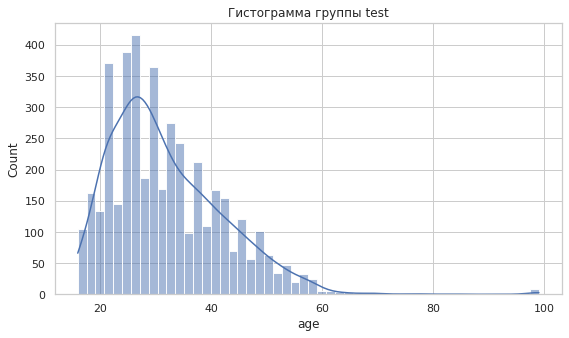

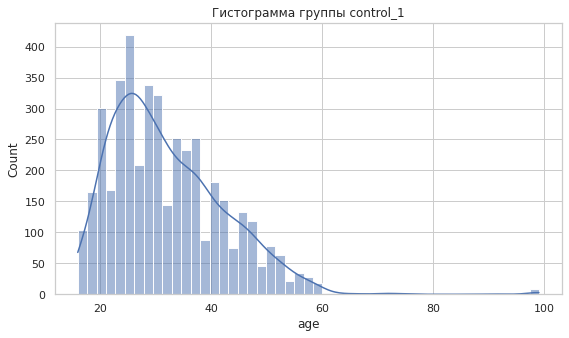

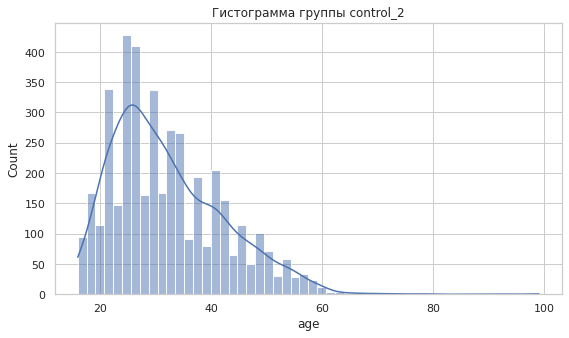

In [181]:
groups = users_all_groups['group'].unique()
for group in groups:
    group_data = users_all_groups[users_all_groups['group'] == group]['age']
    
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(group_data, kde=True)
    plt.title(f'Гистограмма группы {group}')

Будем использовать тест Левена для проверки гомогенности дисперсий. Также сделаем интерпритацию.

In [182]:
stat, p = stats.levene(users_all_groups[users_all_groups['group'] == 'test']['age'],
                       users_all_groups[users_all_groups['group'] == 'control_1']['age'],
                       users_all_groups[users_all_groups['group'] == 'control_2']['age'])
print(f'Тест Левене: Статистика={stat:.3f}, p={p:.3f}')

alpha = 0.05
if p > alpha:
    print('Дисперсии равны (не отвергаем H0)')
else:
    print('Дисперсии не равны (отвергаем H0)')

Тест Левене: Статистика=0.400, p=0.670
Дисперсии равны (не отвергаем H0)


Теперь проведем тест ANOVA и интерпритацию.

In [183]:
f_stat, p_value_anova = stats.f_oneway(users_all_groups[users_all_groups['group'] == 'test']['age'],
                                       users_all_groups[users_all_groups['group'] == 'control_1']['age'],
                                       users_all_groups[users_all_groups['group'] == 'control_2']['age'])
print(f'ANOVA: Статистика F={f_stat:.3f}, p={p_value_anova:.3f}')

alpha = 0.05
if p_value_anova < alpha:
    print('Существует статистически значимая разница между группами (отвергаем H0)')
else:
    print('Нет статистически значимой разницы между группами (не отвергаем H0)')

ANOVA: Статистика F=0.506, p=0.603
Нет статистически значимой разницы между группами (не отвергаем H0)


<h3>4.2. Коэффициент привлекательности</h3>

Данные коэффициента привлекательности количественные, поиск различий по среднему и 3 группы для сравнения. Нужно сделать проверку на удовлетворение парапетрическим условиям: если да, то провести статистический тест ANOVA для проверки равенства средних значений во всех трёх группах.

Предполагаемы гипотезы:
    
H0: Нет различий между выборочными средними в группах.
    
H1: Есть различия хотя бы между двумя группами.

При проведении теста стоит придерживаться определенных требований:
 - Дисперсии внутри каждой из наших групп должны быть примерно одинаковы (требование гомогенности дисперсий). Проверить можно с помощью критерия Бартлетта и критерия Левена.
 - Если объемы групп недостаточно большие (меньше 30) и не совпадают по размерам, то важно соблюдать требование о нормальности распределения выборок.

Гипотезы
 - H0: дисперсии в трёх группах не отличаются.
 - H1: хотя бы одна группа имеет дисперсию отличную от других групп.

Сделаем распределение в группах по коэффициенту привлекательности и построим для наглядности гистограммы.

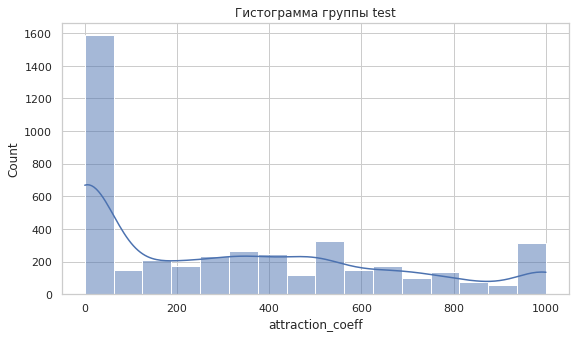

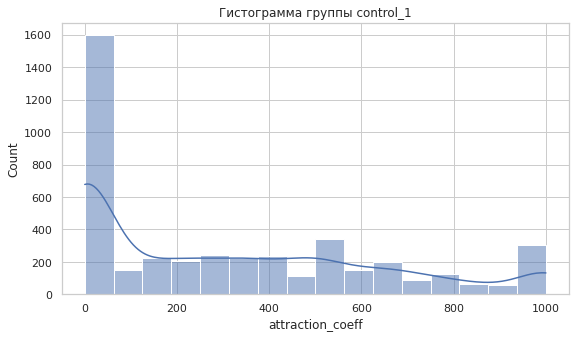

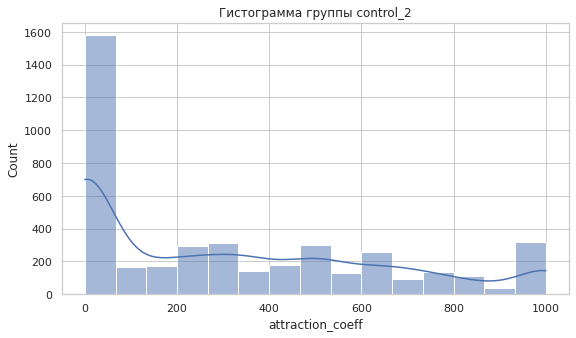

In [184]:
groups = users_all_groups['group'].unique()
for group in groups:
    group_data = users_all_groups[users_all_groups['group'] == group]['attraction_coeff']
    
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(group_data, kde=True)
    plt.title(f'Гистограмма группы {group}')

Будем использовать тест Левена для проверки гомогенности дисперсий. Также сделаем интерпритацию.

In [185]:
stat, p = stats.levene(users_all_groups[users_all_groups['group'] == 'test']['attraction_coeff'],
                       users_all_groups[users_all_groups['group'] == 'control_1']['attraction_coeff'],
                       users_all_groups[users_all_groups['group'] == 'control_2']['attraction_coeff'])
print(f'Тест Левене: Статистика={stat:.3f}, p={p:.3f}')

alpha = 0.05
if p > alpha:
    print('Дисперсии равны (не отвергаем H0)')
else:
    print('Дисперсии не равны (отвергаем H0)')

Тест Левене: Статистика=0.766, p=0.465
Дисперсии равны (не отвергаем H0)


Теперь проведем тест ANOVA и интерпритацию.

In [186]:
f_stat, p_value_anova = stats.f_oneway(users_all_groups[users_all_groups['group'] == 'test']['attraction_coeff'],
                                       users_all_groups[users_all_groups['group'] == 'control_1']['attraction_coeff'],
                                       users_all_groups[users_all_groups['group'] == 'control_2']['attraction_coeff'])
print(f'ANOVA: Статистика F={f_stat:.3f}, p={p_value_anova:.3f}')

alpha = 0.05
if p_value_anova < alpha:
    print('Существует статистически значимая разница между группами (отвергаем H0)')
else:
    print('Нет статистически значимой разницы между группами (не отвергаем H0)')

ANOVA: Статистика F=0.379, p=0.684
Нет статистически значимой разницы между группами (не отвергаем H0)


<h3>4.3. Число монеток (внутренняя валюта)</h3>

Данные коэффициента привлекательности количественные, поиск различий по среднему и 3 группы для сравнения. Нужно сделать проверку на удовлетворение парапетрическим условиям: если да, то провести статистический тест ANOVA для проверки равенства средних значений во всех трёх группах.

Предполагаемы гипотезы:
    
H0: Нет различий между выборочными средними в группах.
    
H1: Есть различия хотя бы между двумя группами.

При проведении теста стоит придерживаться определенных требований:
 - Дисперсии внутри каждой из наших групп должны быть примерно одинаковы (требование гомогенности дисперсий). Проверить можно с помощью критерия Бартлетта и критерия Левена.
 - Если объемы групп недостаточно большие (меньше 30) и не совпадают по размерам, то важно соблюдать требование о нормальности распределения выборок.

Гипотезы
 - H0: дисперсии в трёх группах не отличаются.
 - H1: хотя бы одна группа имеет дисперсию отличную от других групп.

Сделаем распределение в группах по монеткам и построим для наглядности гистограммы.

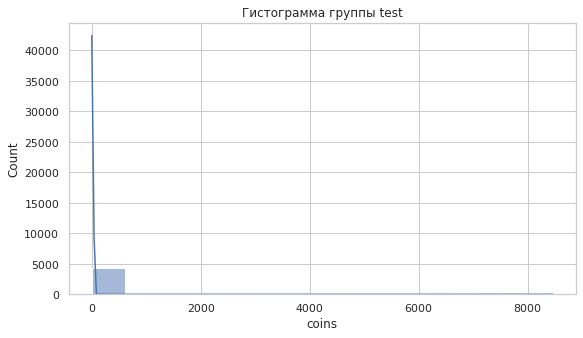

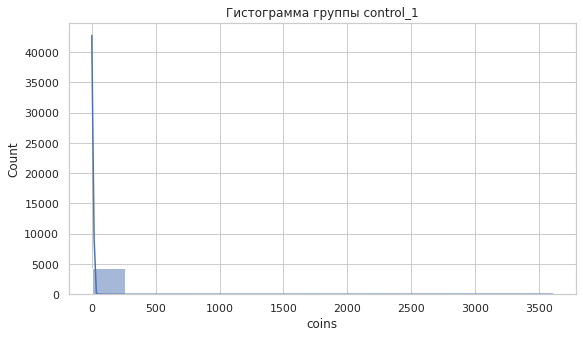

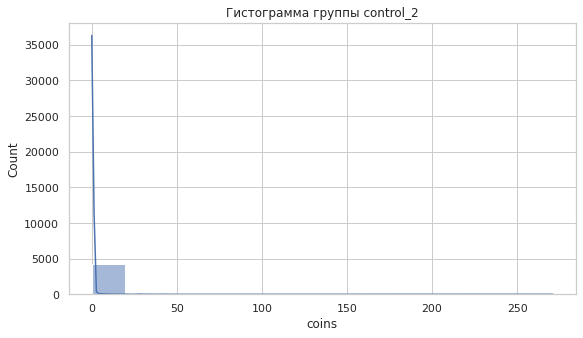

In [187]:
groups = users_all_groups['group'].unique()
for group in groups:
    group_data = users_all_groups[users_all_groups['group'] == group]['coins']
    
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(group_data, kde=True)
    plt.title(f'Гистограмма группы {group}')

Будем использовать тест Левена для проверки гомогенности дисперсий. Также сделаем интерпритацию.

In [188]:
stat, p = stats.levene(users_all_groups[users_all_groups['group'] == 'test']['coins'],
                       users_all_groups[users_all_groups['group'] == 'control_1']['coins'],
                       users_all_groups[users_all_groups['group'] == 'control_2']['coins'])
print(f'Тест Левене: Статистика={stat:.3f}, p={p:.3f}')

alpha = 0.05
if p > alpha:
    print('Дисперсии равны (не отвергаем H0)')
else:
    print('Дисперсии не равны (отвергаем H0)')

Тест Левене: Статистика=0.923, p=0.398
Дисперсии равны (не отвергаем H0)


Теперь проведем тест ANOVA и интерпритацию.

In [189]:
f_stat, p_value_anova = stats.f_oneway(users_all_groups[users_all_groups['group'] == 'test']['coins'],
                                       users_all_groups[users_all_groups['group'] == 'control_1']['coins'],
                                       users_all_groups[users_all_groups['group'] == 'control_2']['coins'])
print(f'ANOVA: Статистика F={f_stat:.3f}, p={p_value_anova:.3f}')

alpha = 0.05
if p_value_anova < alpha:
    print('Существует статистически значимая разница между группами (отвергаем H0)')
else:
    print('Нет статистически значимой разницы между группами (не отвергаем H0)')

ANOVA: Статистика F=0.923, p=0.398
Нет статистически значимой разницы между группами (не отвергаем H0)


<h3>4.4. Страна </h3>

Данные по странам категориальные. Сделаем проверку на наличие различий в распределении категориальных переменных между тремя группами, буду использовать тест хи-квадрат (Chi-squared test).

Предполагаемые гипотезы:

H0: распределение по странам не зависит от группы пользователей.

H1: распределение по странам зависит от группы пользователей.

Для дальнейшей работы сделаем таблицы  сопряженности и проведем тест хи-квадрат. Также сделаем интерпретацию результатов.

In [190]:
cr_table = pd.crosstab(users_all_groups['group'], users_all_groups['country'])
print("Контингентная таблица:")
print(cr_table)

chi2_stat, p_value, dof, expected = stats.chi2_contingency(cr_table)

print(f'\nСтатистика хи-квадрат: {chi2_stat:.3f}')
print(f'p-значение: {p_value:.3f}')
print(f'Степени свободы: {dof}')
print(f'Ожидаемые частоты:\n{expected}')

alpha = 0.05
if p_value < alpha:
    print('Существует статистически значимая разница в распределении по странам по группами (отвергаем H0)')
else:
    print('Нет статистически значимой разницы в распределении по странам между группами (не отвергаем H0)')

Контингентная таблица:
country    Algeria  Argentina  Australia  Azerbaijan  Belgium  Bolivia  \
group                                                                    
control_1        2        389         49           0      108        0   
control_2        0        396         50           0       90        0   
test             2        396         62           1       92        1   

country    Brazil  Canada  Chile  Colombia  ...  Switzerland  Tajikistan  \
group                                       ...                            
control_1       0     134    285         1  ...           42           0   
control_2       0     134    284         2  ...           35           1   
test            1     137    272         1  ...           34           2   

country    Tunisia  Turkey  Ukraine  United Arab Emirates  \
group                                                       
control_1        3       8        8                   207   
control_2        0       5       18       

<h3>4.5. Количество дней, проведенное пользователем в приложении</h3>

Для проведения дальнейшего анализа нах стоит добавить столбец с информацией о том, сколько дней пользователь провел в приложении.

In [191]:
users_all_groups.dtypes

uid                   int64
age                   int64
attraction_coeff      int64
coins               float64
country              object
visit_days           object
gender                int64
age_filter_start      int64
age_filter_end        int64
views_count           int64
was_premium         float64
is_premium          float64
total_revenue         int64
group                object
dtype: object

Для удобства переведем столбец vizit_days в тип данных str. Напишем специальную функцию для обработки этого столбца. Дальше сделаем разделение строки и посчитаем количество уникальных дней.

In [192]:
users_all_groups['visit_days'] = users_all_groups['visit_days'].astype('str')

def process_visit_days(visit_days):
    if visit_days == "0":
        return 0  
    else:
        return len(visit_days.split(','))

users_all_groups['days_spent'] = users_all_groups['visit_days'].apply(process_visit_days)

In [193]:
users_all_groups

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,days_spent
0,892309896,27,685,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,0.0,0.0,0,test,14
1,892044516,27,0,0.0,Germany,0,1,24,30,0,0.0,0.0,0,test,0
2,892185708,45,44,0.0,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,0.0,0.0,0,test,20
3,892130292,32,0,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,0.0,0.0,0,test,12
4,891406035,27,1000,0.0,France,0,1,24,30,1,1.0,0.0,0,test,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4259,891937401,63,242,0.0,Italy,"1,2",1,50,66,33,0.0,0.0,0,control_2,2
4260,891692844,35,500,0.0,France,"1,2,3,4,5,6,8,9,10,11,12,14,16",1,24,45,2,0.0,0.0,0,control_2,13
4261,891096429,41,333,0.0,United States of America,0,1,38,44,6,0.0,0.0,0,control_2,0
4262,891697584,48,210,0.0,United Kingdom (Great Britain),"2,3,5,7,9,10,12,14,15",1,45,51,19,0.0,0.0,0,control_2,9


Данные коэффициента привлекательности количественные, поиск различий по среднему и 3 группы для сравнения. Нужно сделать проверку на удовлетворение парапетрическим условиям: если да, то провести статистический тест ANOVA для проверки равенства средних значений во всех трёх группах.

Предполагаемы гипотезы:
    
H0: Нет различий между выборочными средними в группах.
    
H1: Есть различия хотя бы между двумя группами.

При проведении теста стоит придерживаться определенных требований:
 - Дисперсии внутри каждой из наших групп должны быть примерно одинаковы (требование гомогенности дисперсий). Проверить можно с помощью критерия Бартлетта и критерия Левена.
 - Если объемы групп недостаточно большие (меньше 30) и не совпадают по размерам, то важно соблюдать требование о нормальности распределения выборок.

Гипотезы
 - H0: дисперсии в трёх группах не отличаются.
 - H1: хотя бы одна группа имеет дисперсию отличную от других групп.

Сделаем распределение в группах по количеству проведенных дней в приложении пользователями и построим для наглядности гистограммы.

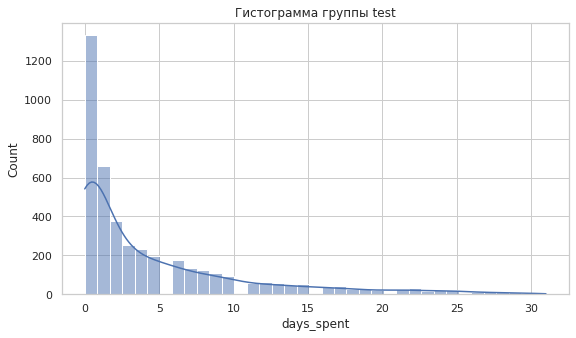

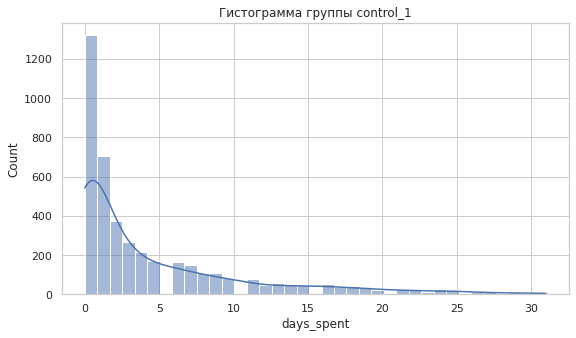

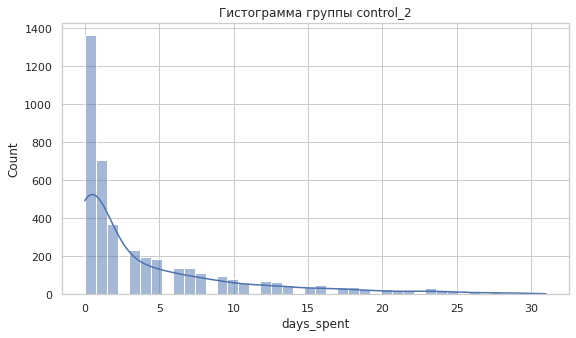

In [194]:
groups = users_all_groups['group'].unique()
for group in groups:
    group_data = users_all_groups[users_all_groups['group'] == group]['days_spent']
    
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(group_data, kde=True)
    plt.title(f'Гистограмма группы {group}')

Будем использовать тест Левена для проверки гомогенности дисперсий. Также сделаем интерпритацию.

In [195]:
stat, p = stats.levene(users_all_groups[users_all_groups['group'] == 'test']['days_spent'],
                       users_all_groups[users_all_groups['group'] == 'control_1']['days_spent'],
                       users_all_groups[users_all_groups['group'] == 'control_2']['days_spent'])
print(f'Тест Левене: Статистика={stat:.3f}, p={p:.3f}')

alpha = 0.05
if p > alpha:
    print('Дисперсии равны (не отвергаем H0)')
else:
    print('Дисперсии не равны (отвергаем H0)')

Тест Левене: Статистика=0.662, p=0.516
Дисперсии равны (не отвергаем H0)


Теперь проведем тест ANOVA и интерпритацию.

In [196]:
f_stat, p_value_anova = stats.f_oneway(users_all_groups[users_all_groups['group'] == 'test']['days_spent'],
                                       users_all_groups[users_all_groups['group'] == 'control_1']['days_spent'],
                                       users_all_groups[users_all_groups['group'] == 'control_2']['days_spent'])
print(f'ANOVA: Статистика F={f_stat:.3f}, p={p_value_anova:.3f}')

alpha = 0.05
if p_value_anova < alpha:
    print('Существует статистически значимая разница между группами (отвергаем H0)')
else:
    print('Нет статистически значимой разницы между группами (не отвергаем H0)')

ANOVA: Статистика F=1.215, p=0.297
Нет статистически значимой разницы между группами (не отвергаем H0)


<h3>4.6. Пол пользователей</h3>

Данные по полу категориальные. Сделаем проверку на наличие различий в распределении категориальных переменных между тремя группами, буду использовать тест хи-квадрат (Chi-squared test).

Предполагаемые гипотезы:

H0: распределение по полу не зависит от группы пользователей.

H1: распределение по полу зависит от группы пользователей.

Необходимо провести подсчет количества пользователей по полу в каждой группе.

In [197]:
gender_distribution = users_all_groups.groupby(['group', 'gender']).size().unstack(fill_value=0)

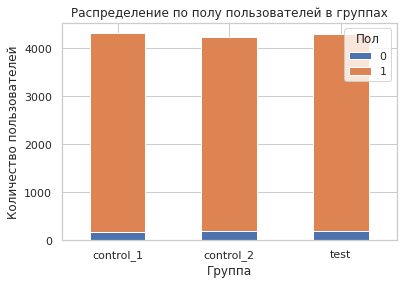

In [198]:
sns.set(style="whitegrid")

gender_distribution.plot(kind='bar', stacked=True)

plt.title('Распределение по полу пользователей в группах')
plt.xlabel('Группа')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=0) 
plt.legend(title='Пол')
plt.show()

Для дальнейшего анализа стот создать таблицы сопряженности и провести тест хи-квадрат.

In [199]:
cr_table = pd.crosstab(users_all_groups['group'], users_all_groups['gender'])
print("Контингентная таблица:")
print(cr_table)

chi2_stat, p_value, dof, expected = stats.chi2_contingency(cr_table)

print(f'\nСтатистика хи-квадрат: {chi2_stat:.3f}')
print(f'p-значение: {p_value:.3f}')
print(f'Степени свободы: {dof}')
print(f'Ожидаемые частоты:\n{expected}')

alpha = 0.05
if p_value < alpha:
    print('Существует статистически значимая разница в распределении пола пользователей по группами (отвергаем H0)')
else:
    print('Нет статистически значимой разницы в распределении пола пользователей между группами (не отвергаем H0)')

Контингентная таблица:
gender       0     1
group               
control_1  182  4132
control_2  193  4043
test       202  4099

Статистика хи-квадрат: 1.211
p-значение: 0.546
Степени свободы: 2
Ожидаемые частоты:
[[ 193.69527663 4120.30472337]
 [ 190.19313672 4045.80686328]
 [ 193.11158665 4107.88841335]]
Нет статистически значимой разницы в распределении пола пользователей между группами (не отвергаем H0)


<h3>4.7. Фильтр поиска, мин. значение</h3>

Данные фильтра поиска количественные, поиск различий по среднему и 3 группы для сравнения. Нужно сделать проверку на удовлетворение парапетрическим условиям: если да, то провести статистический тест ANOVA для проверки равенства средних значений во всех трёх группах.

Предполагаемы гипотезы:
    
H0: Нет различий между выборочными средними в группах.
    
H1: Есть различия хотя бы между двумя группами.

При проведении теста стоит придерживаться определенных требований:
 - Дисперсии внутри каждой из наших групп должны быть примерно одинаковы (требование гомогенности дисперсий). Проверить можно с помощью критерия Бартлетта и критерия Левена.
 - Если объемы групп недостаточно большие (меньше 30) и не совпадают по размерам, то важно соблюдать требование о нормальности распределения выборок.

Гипотезы
 - H0: дисперсии в трёх группах не отличаются.
 - H1: хотя бы одна группа имеет дисперсию отличную от других групп.

Сделаем распределение в группах по минимальному значению фильтра поиска и построим для наглядности гистограммы.

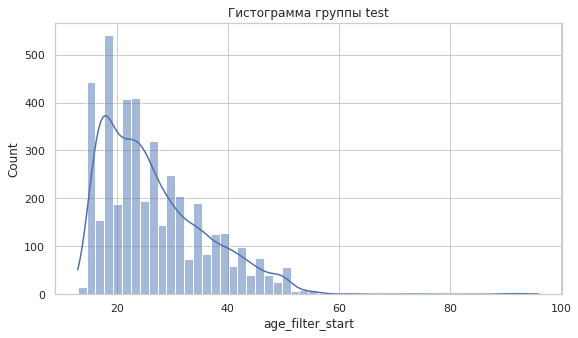

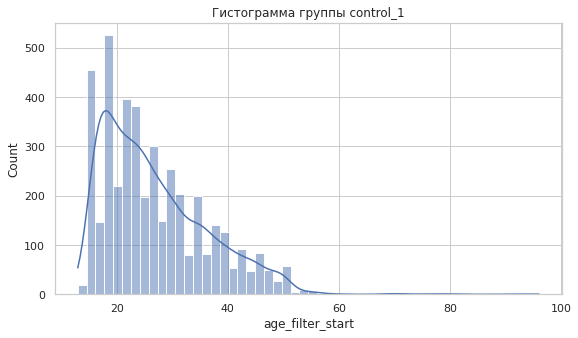

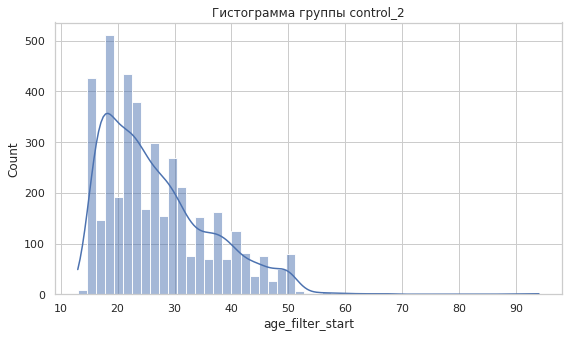

In [200]:
groups = users_all_groups['group'].unique()
for group in groups:
    group_data = users_all_groups[users_all_groups['group'] == group]['age_filter_start']
    
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(group_data, kde=True)
    plt.title(f'Гистограмма группы {group}')

Будем использовать тест Левена для проверки гомогенности дисперсий. Также сделаем интерпритацию.

In [201]:
stat, p = stats.levene(users_all_groups[users_all_groups['group'] == 'test']['age_filter_start'],
                       users_all_groups[users_all_groups['group'] == 'control_1']['age_filter_start'],
                       users_all_groups[users_all_groups['group'] == 'control_2']['age_filter_start'])
print(f'Тест Левене: Статистика={stat:.3f}, p={p:.3f}')

alpha = 0.05
if p > alpha:
    print('Дисперсии равны (не отвергаем H0)')
else:
    print('Дисперсии не равны (отвергаем H0)')

Тест Левене: Статистика=0.749, p=0.473
Дисперсии равны (не отвергаем H0)


Теперь проведем тест ANOVA и интерпритацию.

In [202]:
f_stat, p_value_anova = stats.f_oneway(users_all_groups[users_all_groups['group'] == 'test']['age_filter_start'],
                                       users_all_groups[users_all_groups['group'] == 'control_1']['age_filter_start'],
                                       users_all_groups[users_all_groups['group'] == 'control_2']['age_filter_start'])
print(f'ANOVA: Статистика F={f_stat:.3f}, p={p_value_anova:.3f}')

alpha = 0.05
if p_value_anova < alpha:
    print('Существует статистически значимая разница между группами (отвергаем H0)')
else:
    print('Нет статистически значимой разницы между группами (не отвергаем H0)')

ANOVA: Статистика F=0.824, p=0.439
Нет статистически значимой разницы между группами (не отвергаем H0)


<h3>4.8. Фильтр поиска, макс. значение</h3>

Данные фильтра поиска количественные, поиск различий по среднему и 3 группы для сравнения. Нужно сделать проверку на удовлетворение парапетрическим условиям: если да, то провести статистический тест ANOVA для проверки равенства средних значений во всех трёх группах.

Предполагаемы гипотезы:
    
H0: Нет различий между выборочными средними в группах.
    
H1: Есть различия хотя бы между двумя группами.

При проведении теста стоит придерживаться определенных требований:
 - Дисперсии внутри каждой из наших групп должны быть примерно одинаковы (требование гомогенности дисперсий). Проверить можно с помощью критерия Бартлетта и критерия Левена.
 - Если объемы групп недостаточно большие (меньше 30) и не совпадают по размерам, то важно соблюдать требование о нормальности распределения выборок.

Гипотезы
 - H0: дисперсии в трёх группах не отличаются.
 - H1: хотя бы одна группа имеет дисперсию отличную от других групп.

Сделаем распределение в группах по максимальному значению фильтра поиска и построим для наглядности гистограммы.

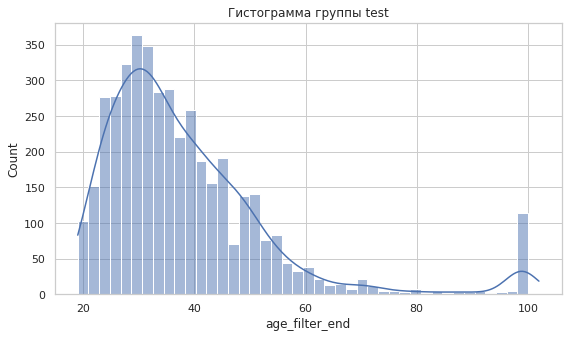

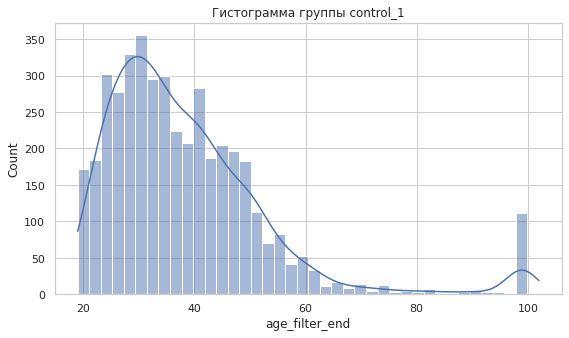

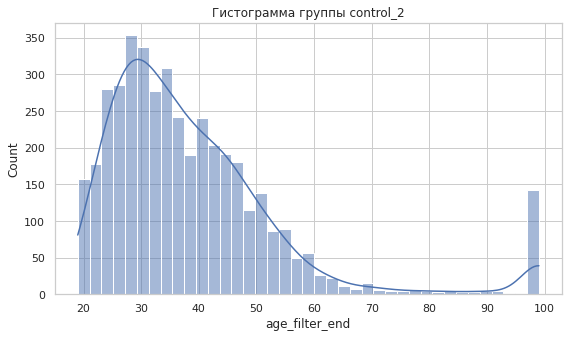

In [203]:
groups = users_all_groups['group'].unique()
for group in groups:
    group_data = users_all_groups[users_all_groups['group'] == group]['age_filter_end']
    
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(group_data, kde=True)
    plt.title(f'Гистограмма группы {group}')

Будем использовать тест Левена для проверки гомогенности дисперсий. Также сделаем интерпритацию.

In [204]:
stat, p = stats.levene(users_all_groups[users_all_groups['group'] == 'test']['age_filter_end'],
                       users_all_groups[users_all_groups['group'] == 'control_1']['age_filter_end'],
                       users_all_groups[users_all_groups['group'] == 'control_2']['age_filter_end'])
print(f'Тест Левене: Статистика={stat:.3f}, p={p:.3f}')

alpha = 0.05
if p > alpha:
    print('Дисперсии равны (не отвергаем H0)')
else:
    print('Дисперсии не равны (отвергаем H0)')

Тест Левене: Статистика=1.106, p=0.331
Дисперсии равны (не отвергаем H0)


Теперь проведем тест ANOVA и интерпритацию.

In [205]:
f_stat, p_value_anova = stats.f_oneway(users_all_groups[users_all_groups['group'] == 'test']['age_filter_end'],
                                       users_all_groups[users_all_groups['group'] == 'control_1']['age_filter_end'],
                                       users_all_groups[users_all_groups['group'] == 'control_2']['age_filter_end'])
print(f'ANOVA: Статистика F={f_stat:.3f}, p={p_value_anova:.3f}')

alpha = 0.05
if p_value_anova < alpha:
    print('Существует статистически значимая разница между группами (отвергаем H0)')
else:
    print('Нет статистически значимой разницы между группами (не отвергаем H0)')

ANOVA: Статистика F=1.906, p=0.149
Нет статистически значимой разницы между группами (не отвергаем H0)


<h3>4.9. Число просмотров</h3>

Данные фильтра поиска количественные, поиск различий по среднему и 3 группы для сравнения. Нужно сделать проверку на удовлетворение парапетрическим условиям: если да, то провести статистический тест ANOVA для проверки равенства средних значений во всех трёх группах.

Предполагаемы гипотезы:
    
H0: Нет различий между выборочными средними в группах.
    
H1: Есть различия хотя бы между двумя группами.

При проведении теста стоит придерживаться определенных требований:
 - Дисперсии внутри каждой из наших групп должны быть примерно одинаковы (требование гомогенности дисперсий). Проверить можно с помощью критерия Бартлетта и критерия Левена.
 - Если объемы групп недостаточно большие (меньше 30) и не совпадают по размерам, то важно соблюдать требование о нормальности распределения выборок.

Гипотезы
 - H0: дисперсии в трёх группах не отличаются.
 - H1: хотя бы одна группа имеет дисперсию отличную от других групп.

Сделаем распределение в группах по числу просмотров и построим для наглядности гистограммы.

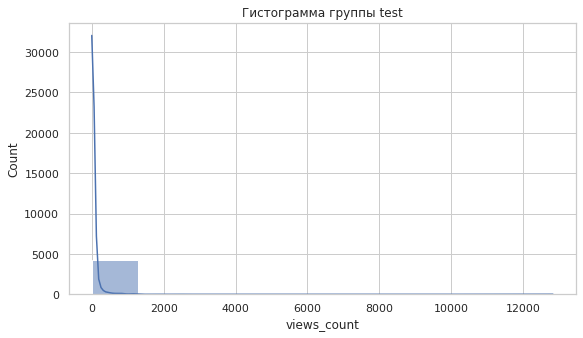

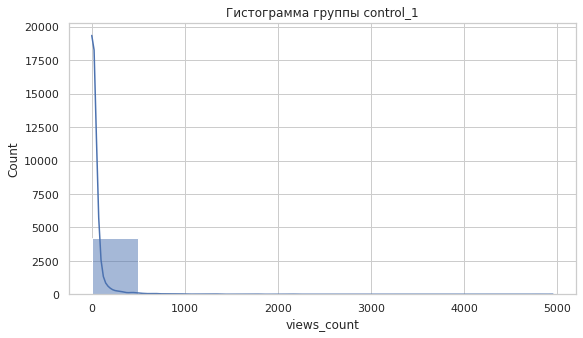

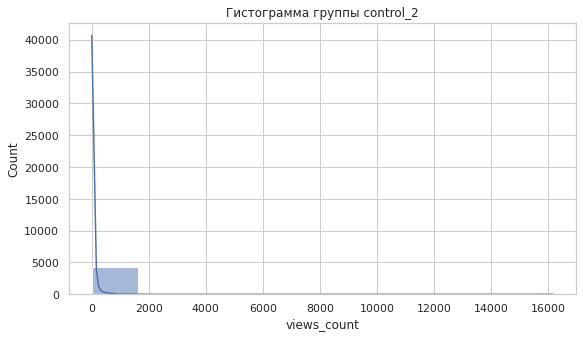

In [206]:
groups = users_all_groups['group'].unique()
for group in groups:
    group_data = users_all_groups[users_all_groups['group'] == group]['views_count']
    
    # Гистограмма
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(group_data, bins=10, kde=True)
    plt.title(f'Гистограмма группы {group}')

Будем использовать тест Левена для проверки гомогенности дисперсий. Также сделаем интерпритацию.

In [207]:
stat, p = stats.levene(users_all_groups[users_all_groups['group'] == 'test']['views_count'],
                       users_all_groups[users_all_groups['group'] == 'control_1']['views_count'],
                       users_all_groups[users_all_groups['group'] == 'control_2']['views_count'])
print(f'Тест Левене: Статистика={stat:.3f}, p={p:.3f}')

alpha = 0.05
if p > alpha:
    print('Дисперсии равны (не отвергаем H0)')
else:
    print('Дисперсии не равны (отвергаем H0)')

Тест Левене: Статистика=0.867, p=0.420
Дисперсии равны (не отвергаем H0)


Теперь проведем тест ANOVA и интерпритацию.

In [208]:
f_stat, p_value_anova = stats.f_oneway(users_all_groups[users_all_groups['group'] == 'test']['views_count'],
                                       users_all_groups[users_all_groups['group'] == 'control_1']['views_count'],
                                       users_all_groups[users_all_groups['group'] == 'control_2']['views_count'])
print(f'ANOVA: Статистика F={f_stat:.3f}, p={p_value_anova:.3f}')

alpha = 0.05
if p_value_anova < alpha:
    print('Существует статистически значимая разница между группами (отвергаем H0)')
else:
    print('Нет статистически значимой разницы между группами (не отвергаем H0)')

ANOVA: Статистика F=0.866, p=0.421
Нет статистически значимой разницы между группами (не отвергаем H0)


### Вывод

По всем полученным данным в этом разделе можно сделать вывод о том, что система спитования отработала хорошо.  
Мы проверили, что пользователи распредились по свои группам случайно. А также их сравнение не дало статистически значимых различий.

<h2> 5. A/B тестирование</h2>

Сначала нам необходимо определиться с метриками, которые отражают успешность эксперимента.  
Как показатель удачного функционирования компании можно взять прибыльность продукта.   
Для это возьмем метрику - ARPPU (средний дход на платящего пользователя).  
Не стоит забывать о пользователях, которые купили премиум. Для них будем учитывать метрику CR (конверсия пользователя в премиум-подписчики).  
Если в ходе проведения эксперимента эти показатели остались неизменными или снизились, то мы понимаем, что эксперимент оказался неудачным и не стоит применять нововведения для всех пользователей.

### Найдем CR

In [209]:
transactions_test.shape

(257, 8)

In [210]:
transactions_control_1.shape

(325, 8)

In [211]:
transactions_control_2.shape

(303, 8)

Стоит добавить во все таблицы с транзакциями колонку group.  
Потом сделаем объединение всех транзакций в один датафрейм.

In [212]:
transactions_test['group']='test'
transactions_control_1['group']='control_1'
transactions_control_2['group']='control_2'

In [213]:
transactions_all_groups=pd.concat([transactions_test, transactions_control_1, transactions_control_2])
transactions_all_groups.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
0,891345942,Italy,2017-11-05 13:00:00,2017-11-13 15:04:00,12909.0,147.0,trial_vip_popup,trial_premium,test
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923.0,147.0,trial_vip_popup,trial_premium,test
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783.0,67.0,menu,other_type,test
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783.0,67.0,menu,other_type,test
4,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087.0,147.0,trial_vip_popup,trial_premium,test


In [214]:
transactions_all_groups.shape

(885, 9)

In [215]:
transactions_all_groups.product_type.value_counts()

coins               318
premium_no_trial    284
trial_premium       181
other_type          102
Name: product_type, dtype: int64

Теперь отфильтруем транзакции и оставим только с премиумом-подиской.  
Потом добавим в данные с пользователями графу premium с категориальными данными: 1 - премиум-подписка, 0 - нет премиум-подписки.  
И сделаем преобразование типа данных.

In [216]:
premium=transactions_all_groups.query('product_type=="premium_no_trial"')

users_all_groups['premium']=users_all_groups['uid'].isin(premium['uid'])

users_all_groups['premium']=users_all_groups['premium'].astype('int')

In [217]:
users_all_groups

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,days_spent,premium
0,892309896,27,685,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,0.0,0.0,0,test,14,0
1,892044516,27,0,0.0,Germany,0,1,24,30,0,0.0,0.0,0,test,0,0
2,892185708,45,44,0.0,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,0.0,0.0,0,test,20,0
3,892130292,32,0,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,0.0,0.0,0,test,12,0
4,891406035,27,1000,0.0,France,0,1,24,30,1,1.0,0.0,0,test,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4259,891937401,63,242,0.0,Italy,"1,2",1,50,66,33,0.0,0.0,0,control_2,2,0
4260,891692844,35,500,0.0,France,"1,2,3,4,5,6,8,9,10,11,12,14,16",1,24,45,2,0.0,0.0,0,control_2,13,0
4261,891096429,41,333,0.0,United States of America,0,1,38,44,6,0.0,0.0,0,control_2,0,0
4262,891697584,48,210,0.0,United Kingdom (Great Britain),"2,3,5,7,9,10,12,14,15",1,45,51,19,0.0,0.0,0,control_2,9,0


In [218]:
data_for_CR_users=users_all_groups.groupby('group', as_index=False)\
                                  .agg({'uid':'nunique'})\
                                  .rename(columns={'uid':'users'})
data_for_CR_users

,group,users
0,control_1,4314
1,control_2,4236
2,test,4301


In [219]:
data_for_CR_users_pr=users_all_groups.query('premium==1')\
                                     .groupby('group', as_index=False)\
                                     .agg({'uid':'nunique'})\
                                     .rename(columns={'uid':'users_with_premium'})
data_for_CR_users_pr

,group,users_with_premium
0,control_1,97
1,control_2,100
2,test,66


In [220]:
data_for_CR=pd.merge(data_for_CR_users, data_for_CR_users_pr, on='group')
data_for_CR

,group,users,users_with_premium
0,control_1,4314,97
1,control_2,4236,100
2,test,4301,66


In [221]:
data_for_CR['CR']=(data_for_CR.users_with_premium/data_for_CR.users).round(4)
data_for_CR

,group,users,users_with_premium,CR
0,control_1,4314,97,0.0225
1,control_2,4236,100,0.0236
2,test,4301,66,0.0153


По полученным данным можно отметить, что конверсия в пользователей с премиум-подпиской снизалась.  
Стоит проверить еще с помощью статистики.

Для этого оставим пользователей только из контрольных групп.

In [222]:
users_control_groups=users_all_groups.query('group=="control_1" | group=="control_2"')
users_control_groups

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,days_spent,premium
0,892319115,25,435,0.0,United States of America,"1,2,3,4,5,6",0,22,32,982,0.0,0.0,0,control_1,6,0
1,891248523,29,500,0.0,United States of America,"1,2",1,26,32,12,0.0,0.0,0,control_1,2,0
2,891670932,33,800,0.0,France,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,0.0,0.0,0,control_1,10,0
3,891060786,26,0,0.0,Argentina,"1,2,3,4,5",1,23,29,0,0.0,0.0,0,control_1,5,0
4,892006554,35,294,0.0,United States of America,"1,2,3,5,6,7,8,9,10,12,15,16,17,19",1,30,40,17,0.0,0.0,0,control_1,14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4259,891937401,63,242,0.0,Italy,"1,2",1,50,66,33,0.0,0.0,0,control_2,2,0
4260,891692844,35,500,0.0,France,"1,2,3,4,5,6,8,9,10,11,12,14,16",1,24,45,2,0.0,0.0,0,control_2,13,0
4261,891096429,41,333,0.0,United States of America,0,1,38,44,6,0.0,0.0,0,control_2,0,0
4262,891697584,48,210,0.0,United Kingdom (Great Britain),"2,3,5,7,9,10,12,14,15",1,45,51,19,0.0,0.0,0,control_2,9,0


Предполагаемые гипотезы:

H0: соотношение числа пользователей с премиумом с общим числом пользователей в контрольных группах равны.

H1: соотношение числа пользователей с премиумом с общим числом пользователей в контрольных группах не равны.

Создадим таблицы сопряженности и проведем тест хи-квадрат.

In [223]:
cr_table = pd.crosstab(users_control_groups['group'], users_control_groups['premium'])
cr_table

premium,0,1
group,,
control_1,4217,97
control_2,4136,100


In [224]:
chi2_stat, p_value, dof, expected = stats.chi2_contingency(cr_table)

print(f'\nСтатистика хи-квадрат: {chi2_stat:.3f}')
print(f'p-значение: {p_value:.3f}')
print(f'Степени свободы: {dof}')
print(f'Ожидаемые частоты:\n{expected}')

alpha = 0.05
if p_value < alpha:
    print('Существует статистически значимая разница в соотношение числа пользователей с премиумом с общим числом пользователей в контрольных группах  (отвергаем H0)')
else:
    print('Нет статистически значимой разницы в соотношение числа пользователей с премиумом с общим числом пользователей в контрольных группах (не отвергаем H0)')


Статистика хи-квадрат: 0.075
p-значение: 0.784
Степени свободы: 1
Ожидаемые частоты:
[[4214.60140351   99.39859649]
 [4138.39859649   97.60140351]]
Нет статистически значимой разницы в соотношение числа пользователей с премиумом с общим числом пользователей в контрольных группах (не отвергаем H0)


Теперь оставим только пользователей из тестовой и первой контрольной групп.

In [225]:
users_control_1_test_groups=users_all_groups.query('group=="control_1" | group=="test"')
users_control_1_test_groups

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,days_spent,premium
0,892309896,27,685,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,0.0,0.0,0,test,14,0
1,892044516,27,0,0.0,Germany,0,1,24,30,0,0.0,0.0,0,test,0,0
2,892185708,45,44,0.0,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,0.0,0.0,0,test,20,0
3,892130292,32,0,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,0.0,0.0,0,test,12,0
4,891406035,27,1000,0.0,France,0,1,24,30,1,1.0,0.0,0,test,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4335,892022304,26,227,0.0,United States of America,0,0,23,29,427,0.0,0.0,0,control_1,0,0
4336,891905022,38,200,0.0,Argentina,"1,2,3,4,5,6,7,8,9,10,11,13,14,15,16,21",1,20,50,5,0.0,0.0,0,control_1,16,0
4337,891304722,49,411,0.0,United States of America,1,1,46,52,17,0.0,0.0,0,control_1,1,0
4338,891302328,27,0,0.0,United States of America,"1,3,5",1,24,30,0,0.0,0.0,0,control_1,3,0


Предполагаемые гипотезы:

H0: соотношение числа пользователей с премиумом с общим числом пользователей в тестовой и контрольных группах равны.

H1: соотношение числа пользователей с премиумом с общим числом пользователей в тестовой и контрольных группах не равны.

Создадим таблицы сопряженности и проведем тест хи-квадрат.

In [226]:
cr_table_2 = pd.crosstab(users_control_1_test_groups['group'], users_control_1_test_groups['premium'])
cr_table_2

premium,0,1
group,,
control_1,4217,97
test,4235,66


In [227]:
chi2_stat, p_value, dof, expected = stats.chi2_contingency(cr_table_2)

print(f'\nСтатистика хи-квадрат: {chi2_stat:.3f}')
print(f'p-значение: {p_value:.3f}')
print(f'Степени свободы: {dof}')
print(f'Ожидаемые частоты:\n{expected}')

alpha = 0.05
if p_value < alpha:
    print('Существует статистически значимая разница в соотношение числа пользователей с премиумом с общим числом пользователей в тестовой и контрольных группах  (отвергаем H0)')
else:
    print('Нет статистически значимой разницы в соотношение числа пользователей с премиумом с общим числом пользователей в тестовой и контрольных группах (не отвергаем H0)')


Статистика хи-квадрат: 5.536
p-значение: 0.019
Степени свободы: 1
Ожидаемые частоты:
[[4232.37701683   81.62298317]
 [4219.62298317   81.37701683]]
Существует статистически значимая разница в соотношение числа пользователей с премиумом с общим числом пользователей в тестовой и контрольных группах  (отвергаем H0)


### Конверсия в пользователей с премиум-подпиской статистически значимо снизилась в тестовой группе. Принимаем альтернативную гипотезу.

### Найдем ARPPU

In [228]:
premium

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
5,892426491,United States of America,2017-10-14 10:13:00,2017-10-15 22:39:00,12597.0,147.0,autoreply_message,premium_no_trial,test
6,891558921,United States of America,2017-11-01 03:07:00,2017-11-10 09:05:00,9100.0,147.0,left_sidebar_menu,premium_no_trial,test
11,891861048,Canada,2017-10-26 02:55:00,2017-11-10 19:00:00,3588.0,68.0,none,premium_no_trial,test
12,891178380,Spain,2017-11-08 03:54:00,2017-11-09 21:53:00,113477.0,147.0,promo_09,premium_no_trial,test
21,891312873,Italy,2017-11-05 21:22:00,2017-11-10 21:51:00,7852.0,147.0,promo_09,premium_no_trial,test
...,...,...,...,...,...,...,...,...,...
316,891393735,Spain,2017-11-04 17:31:00,2017-11-04 18:05:00,6292.0,147.0,dating,premium_no_trial,control_2
317,892053750,United States of America,2017-10-22 00:46:00,2017-10-28 08:12:00,6292.0,147.0,autoreply_message,premium_no_trial,control_2
320,892032072,United Kingdom (Great Britain),2017-10-22 14:21:00,2017-10-23 15:37:00,3588.0,68.0,none,premium_no_trial,control_2
322,891435993,Canada,2017-11-03 21:08:00,2017-11-03 21:26:00,3549.0,68.0,none,premium_no_trial,control_2


Рассчитаем общий доход от платящих пользователей.

In [229]:
total_revenue_premium = premium.groupby('group', as_index=False)\
                             .agg({'revenue':'sum', 'uid':'nunique'})\
                             .rename(columns={'revenue':'total_revenue', 'uid':'number_of_paying_users'})
total_revenue_premium

,group,total_revenue,number_of_paying_users
0,control_1,766545.0,99
1,control_2,736034.0,101
2,test,801489.0,67


In [230]:
total_revenue_premium['ARPPU'] = (total_revenue_premium.total_revenue/total_revenue_premium.number_of_paying_users).round(2)
total_revenue_premium

,group,total_revenue,number_of_paying_users,ARPPU
0,control_1,766545.0,99,7742.88
1,control_2,736034.0,101,7287.47
2,test,801489.0,67,11962.52


По полученным данным ми видим, что средний доход платящего пользователя увеличился в тестовой группе.

Дальше для сравнения будет использоваться или t-test или U-тест Манна-Уитни (данные количественные, тип вопроса поиск различий средних, 2 группы для сравнения: 2 контрольные между собой и контрольная+тест). Для определения теста, который будет использоваться нужно проверить, что данные в группах распределены нормально и имеют одинаковую дисперсию.   

In [231]:
data_premium_users_groups = premium.groupby(['group','uid'], as_index=False)\
                                 .agg({'revenue':'sum'})
data_premium_users_groups

,group,uid,revenue
0,control_1,891092322,5278.0
1,control_1,891120969,6292.0
2,control_1,891130164,4537.0
3,control_1,891131061,6292.0
4,control_1,891142386,4680.0
...,...,...,...
262,test,892370097,11115.0
263,test,892390170,5369.0
264,test,892405179,9100.0
265,test,892426491,12597.0


Для наглядности построим график.

Text(0, 0.5, 'Частота')

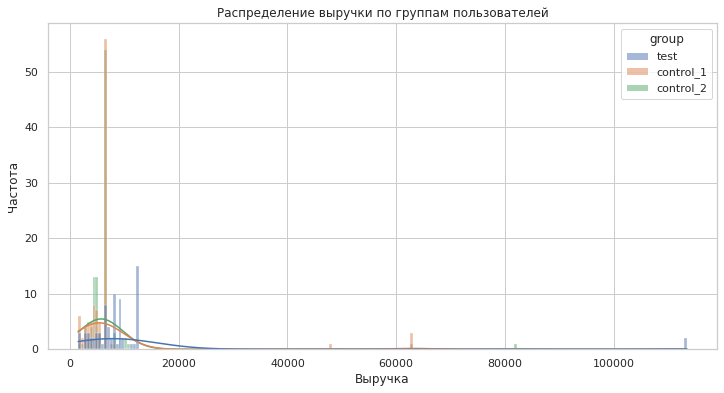

In [232]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
sns.histplot(data = premium, x="revenue", hue="group", kde=True)
plt.title('Распределение выручки по группам пользователей')
plt.xlabel('Выручка')
plt.ylabel('Частота')

Предполагаемые гипотезы:

H0: Данные распределены нормально.

H1: Распределение данных отклоняется от нормального.

Если pvalue<0.05, данные распределены не нормально, нулевая гипотеза отвергается.

In [233]:
premium_control_1=premium.query('group=="control_1"')

In [234]:
premium_control_2=premium.query('group=="control_2"')

In [235]:
premium_test=premium.query('group=="test"')

In [236]:
stats.shapiro(premium_control_1.revenue)

ShapiroResult(statistic=0.2985817790031433, pvalue=4.6688506846716524e-20)

In [237]:
stats.shapiro(premium_control_2.revenue)

ShapiroResult(statistic=0.2335934042930603, pvalue=6.037307755482551e-21)

In [238]:
stats.shapiro(premium_test.revenue)

ShapiroResult(statistic=0.2978513836860657, pvalue=3.562410472275999e-17)

По полученным данным мы видим, что они распределены не нормально во всех группах.  
Поскольку нам нужно сравнить ARPPU (явл. ср. арифметическим) будет использоваться t-test.

Предполагаемые гипотезы:

H0: Дисперсии во всех трёх группах равны.

H1:  Хотя бы одна группа имеет дисперсию отличную от друх групп. 

Будем использовать тест Левена для проверки гомогенности дисперсий.

In [239]:
stat, p = stats.levene(premium[premium['group'] == 'test']['revenue'],
                       premium[premium['group'] == 'control_1']['revenue'],
                       premium[premium['group'] == 'control_2']['revenue'])
print(f'Тест Левене: Статистика={stat:.3f}, p={p:.3f}')

alpha = 0.05
if p > alpha:
    print('Дисперсии равны (не отвергаем H0)')
else:
    print('Дисперсии не равны (отвергаем H0)')

Тест Левене: Статистика=1.504, p=0.224
Дисперсии равны (не отвергаем H0)


Теперь проведем t-test между двумя контрольными группами.

Предполагаемые гипотезы: 

H0: статистически значимого различия средних значений ARPPU в контрольных группах нет.

H1: есть статистически значимое различие средних значений ARPPU в контрольных группах.

In [240]:
stat_ttest, p_ttest = ss.ttest_ind(premium_control_1.revenue, premium_control_2.revenue)

print(f"Статистика t-теста: {stat_ttest}, P-значение: {p_ttest}")

alpha = 0.05
if p_ttest < alpha:
    print("Отвергаем нулевую гипотезу: средние значения групп различны.")
else:
    print("Не можем отвергнуть нулевую гипотезу: средние значения групп не различны.")

Статистика t-теста: 0.26067813326542766, P-значение: 0.7945998695199628
Не можем отвергнуть нулевую гипотезу: средние значения групп не различны.


Теперь проведем t-test между контрольной группой и тестовой группой.

Предполагаемые гипотезы:

H0: статистически значимого различия средних значений ARPPU в контрольной и тестовой группах нет.

H1: есть статистически значимое различие средних значений ARPPU в контрольной и тестовой группах.

In [241]:
stat_ttest, p_ttest = ss.ttest_ind(premium_control_1.revenue, premium_test.revenue)

print(f"Статистика t-теста: {stat_ttest}, P-значение: {p_ttest}")

alpha = 0.05
if p_ttest < alpha:
    print("Отвергаем нулевую гипотезу: средние значения групп различны.")
else:
    print("Не можем отвергнуть нулевую гипотезу: средние значения групп не различны.")

Статистика t-теста: -1.5784110595537584, P-значение: 0.11625669460441285
Не можем отвергнуть нулевую гипотезу: средние значения групп не различны.


По всем полученным данным видим, что ARPPU статистически значимо не изменился.  
Не принимаем эту альтернативную гипотезу.

## 6. Вывод

По проведенному A/B-тесту было выявлено, что эксперимент не увенчался успехом и нам не стоитизменять стоимость премиум-подписки.  
Увидели, что конверсия пользователя в премиум-подписчика статистически значимо снизалась. При этом средний доход с платящего пользователя статистически значимо не изменился.